In this post we will cover how to implement a logistic regression model using PyTorch in Python.

We will use the Sklearn breast cancer dataset, an open source dataset already used previously in some of my previous article to train a binary classification model.

The goal is to explain how to:

- go from a pandas dataframe to PyTorch’s Datasets and DataLoaders
- create a neural network for binary classification in PyTorch
- create predictions
- evaluate the performance of our model with utility functions and matplotlib
- use this network to make predictions

# Import and explore the dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.datasets import load_breast_cancer

breast_cancer_dataset = load_breast_cancer(as_frame=True, return_X_y=True)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
torch.__version__

'1.12.1'

In [3]:
df = breast_cancer_dataset[0]
df["target"] = breast_cancer_dataset[1]
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


Our goal is to create a model that can predict the target column based on the characteristics in the other columns.

                                             |                                             | [  0%]   00:00 ->…


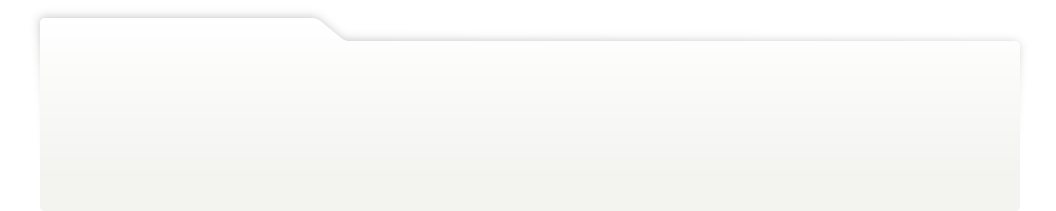
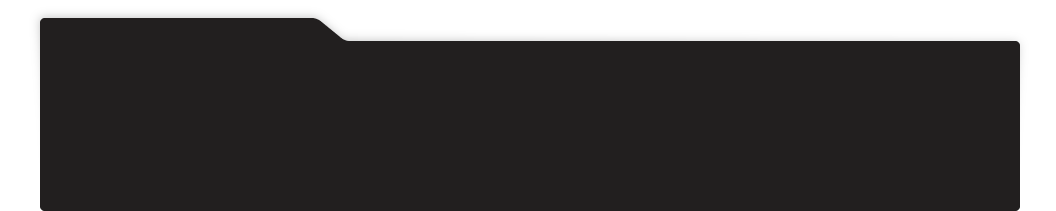
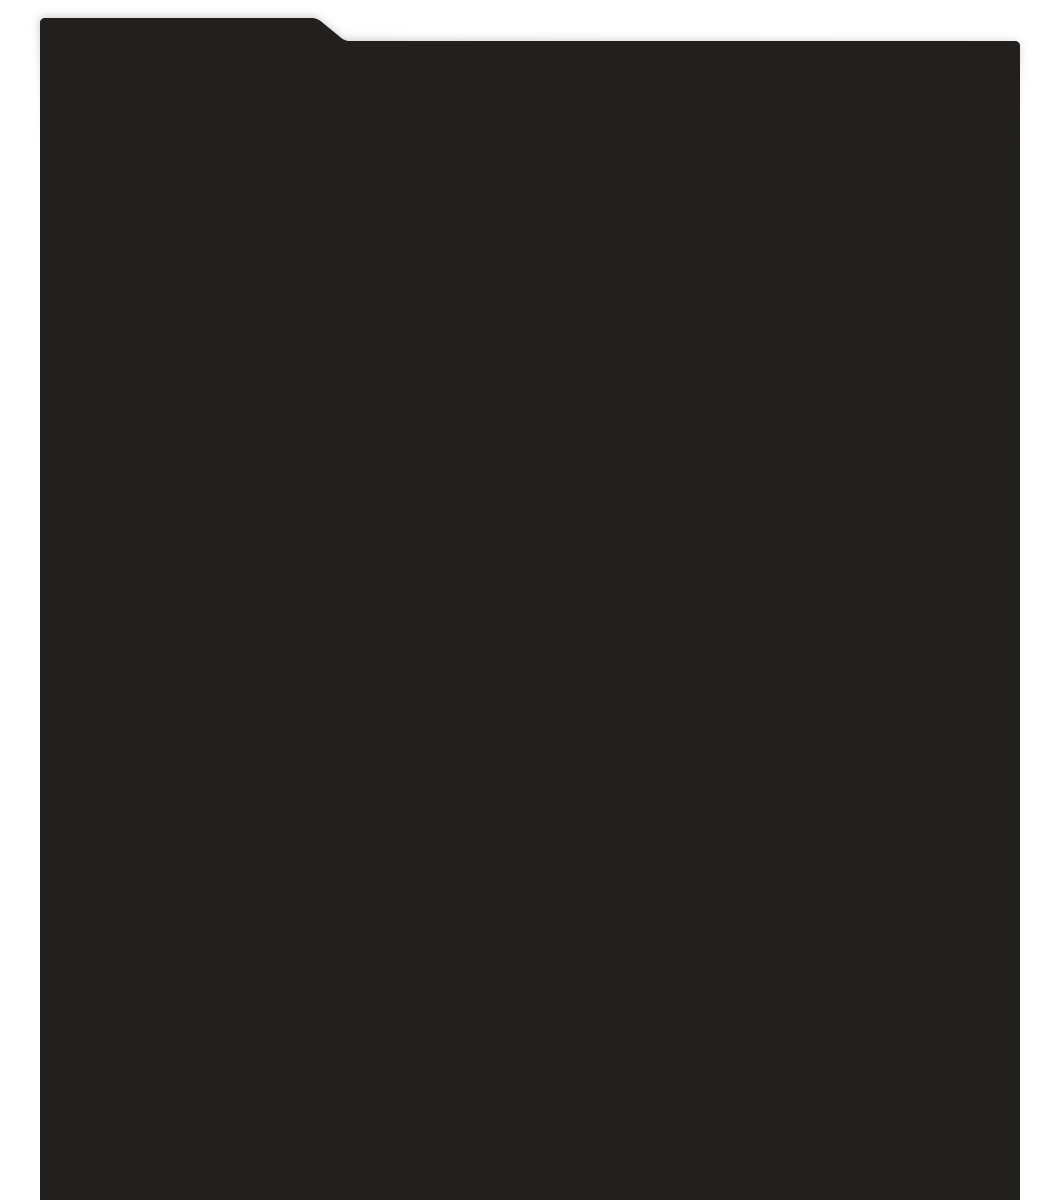
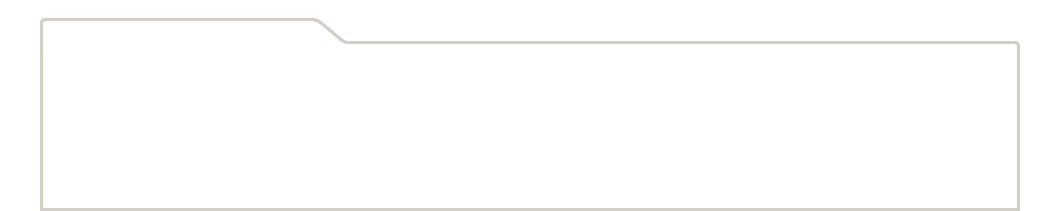
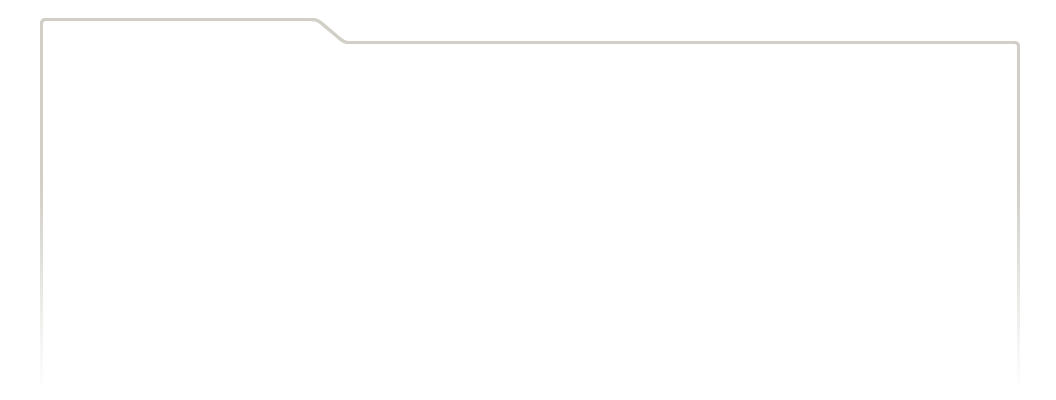
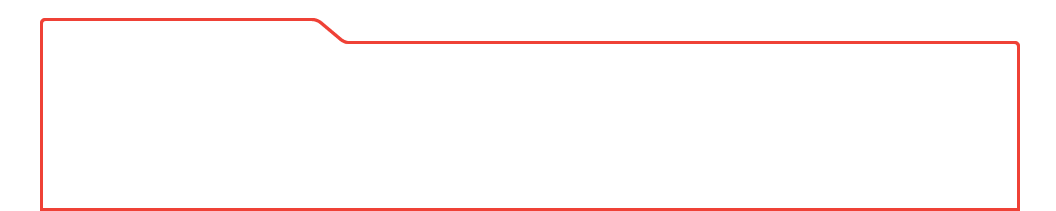
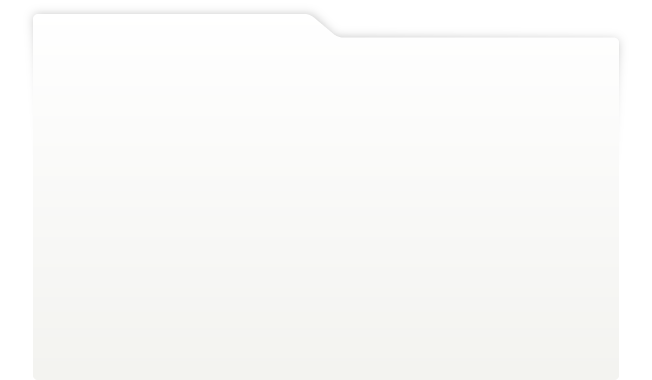
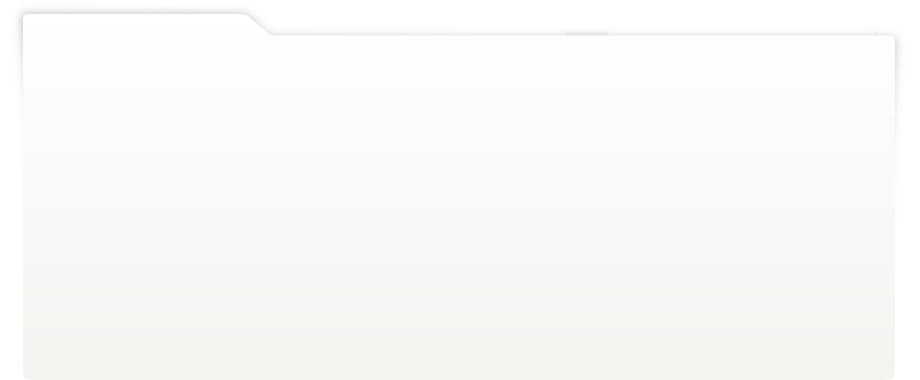
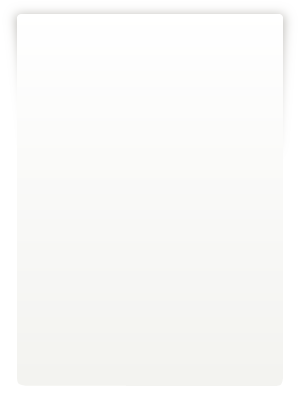
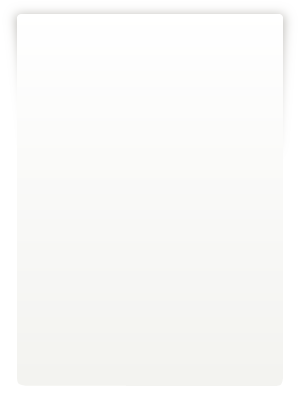
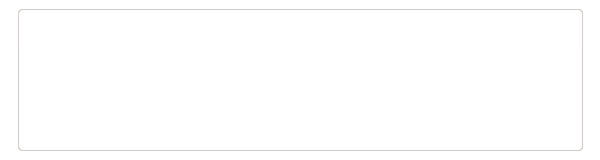
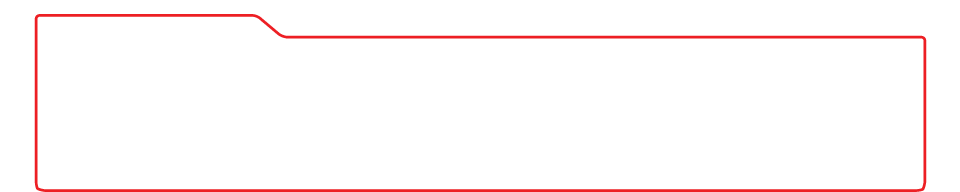
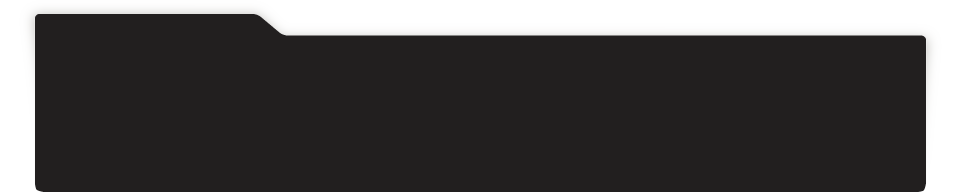
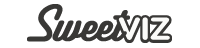
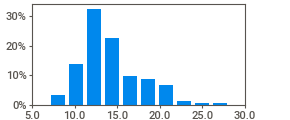
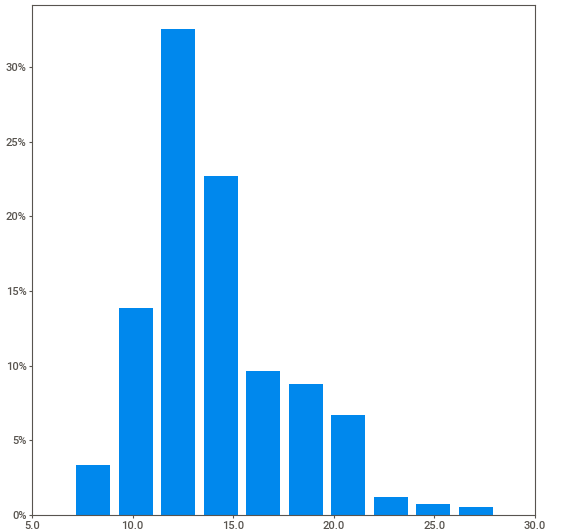
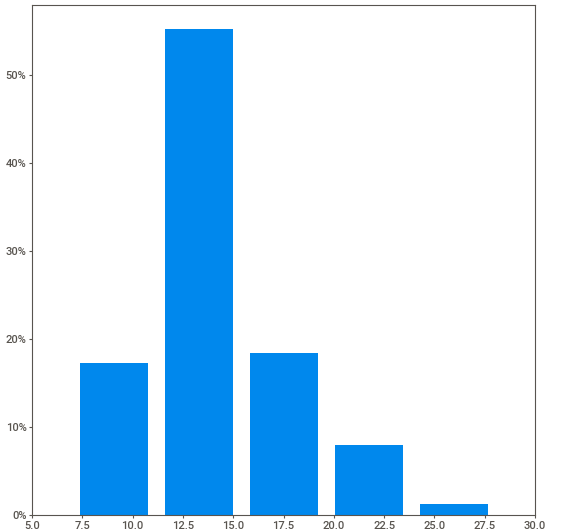
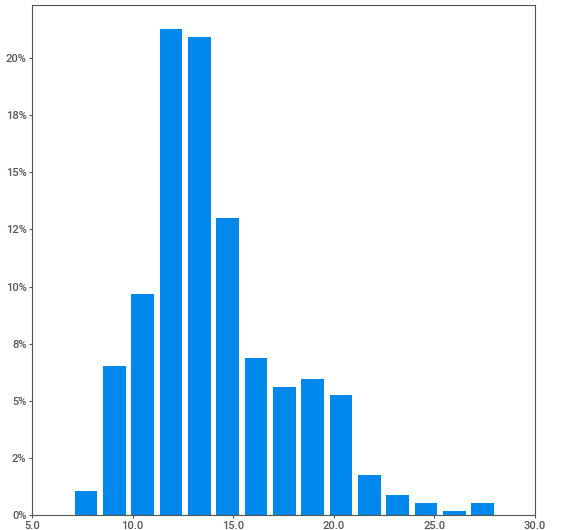
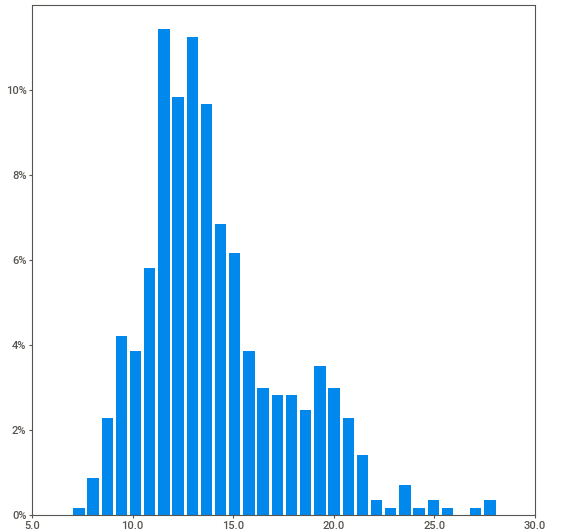
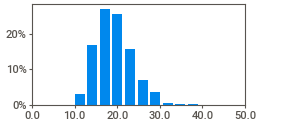
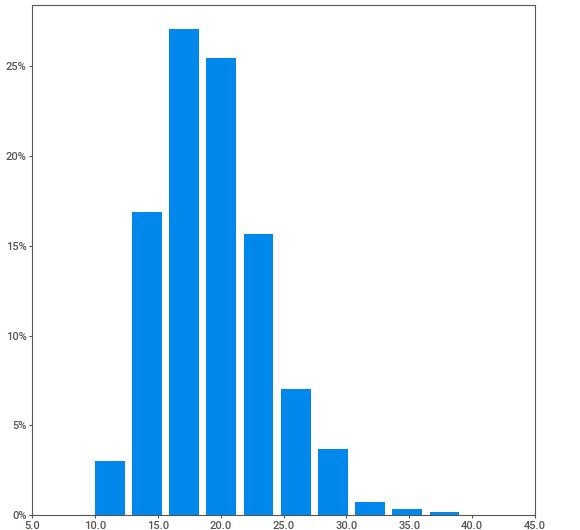
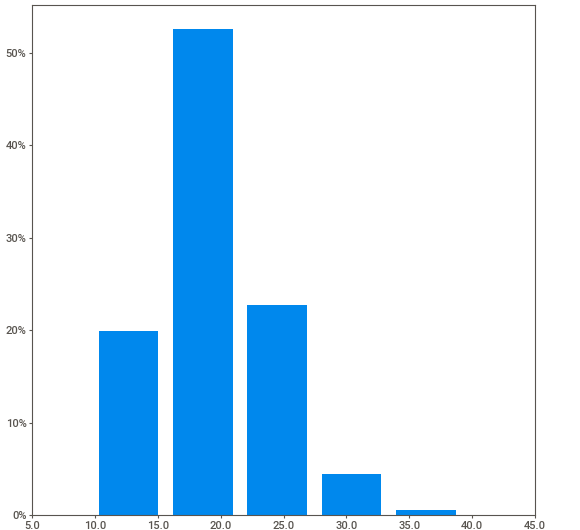
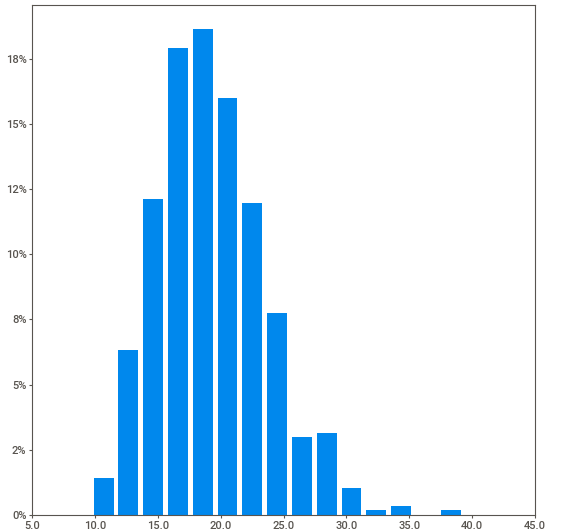
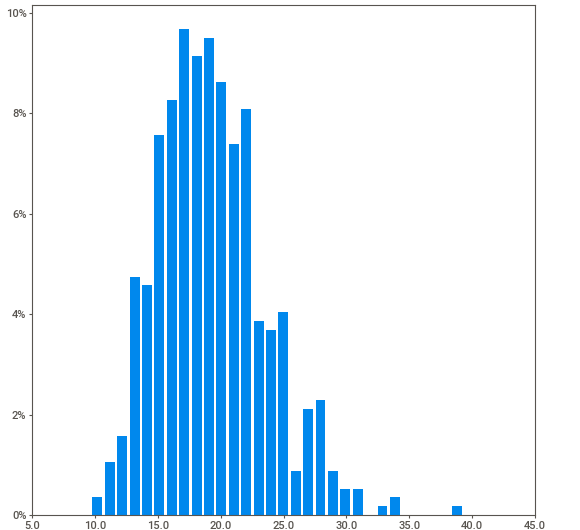
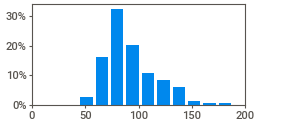
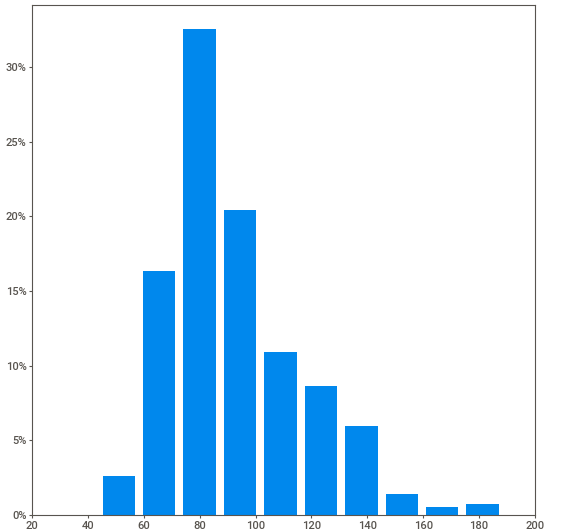
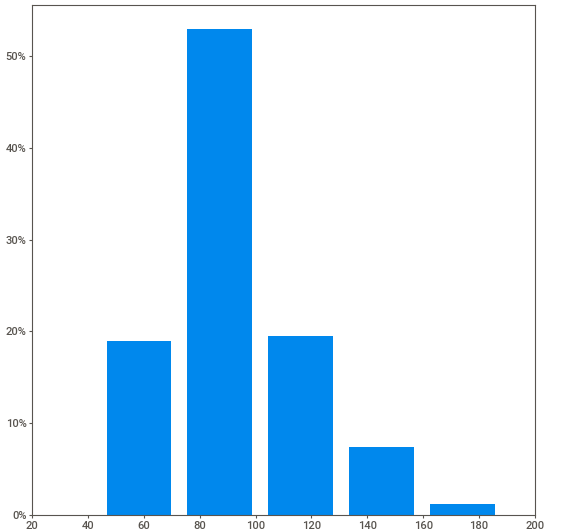
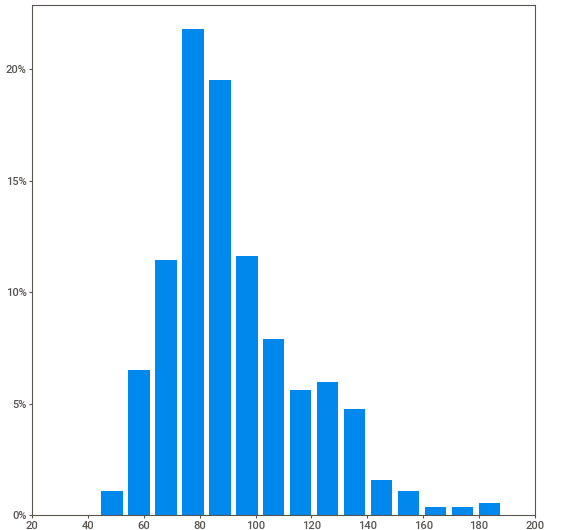
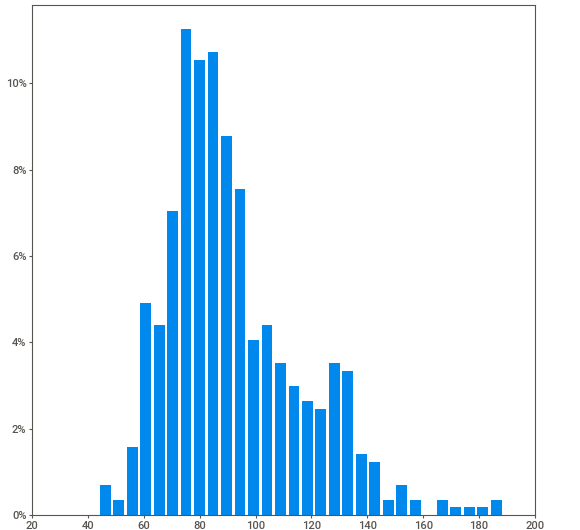
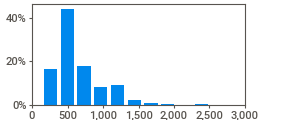
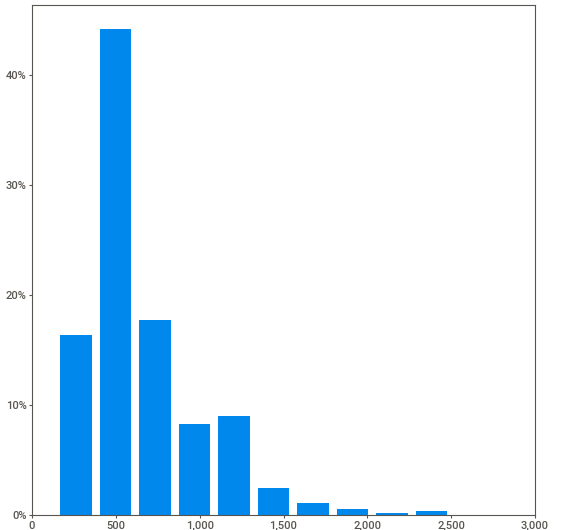
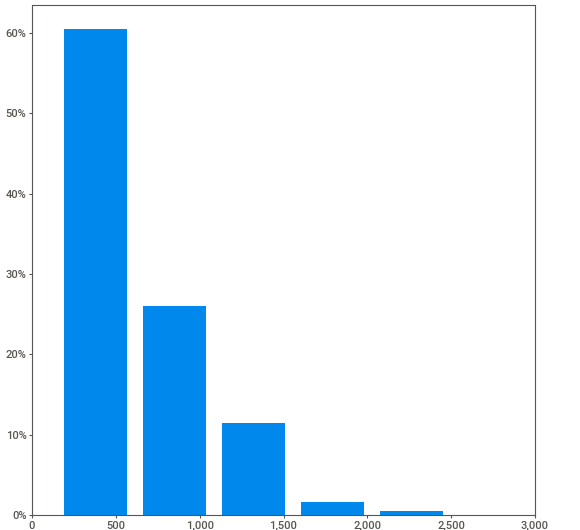
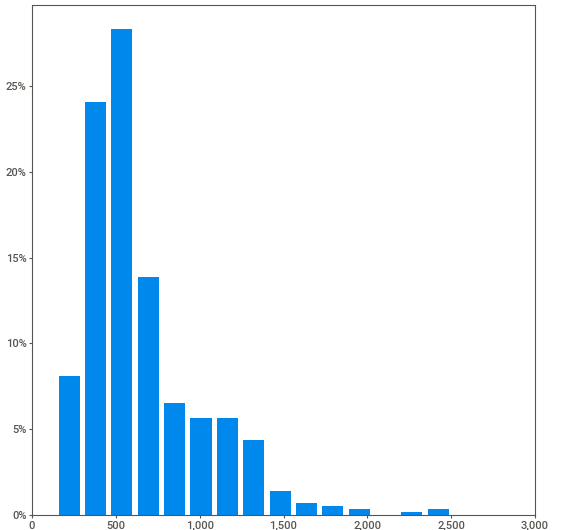
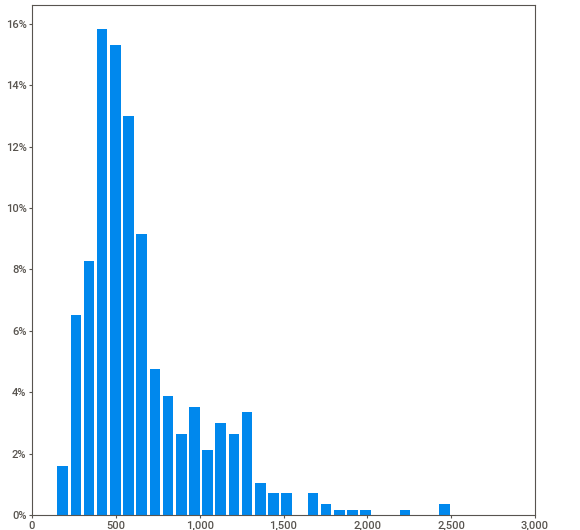
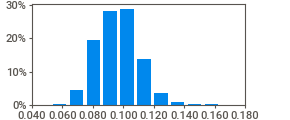
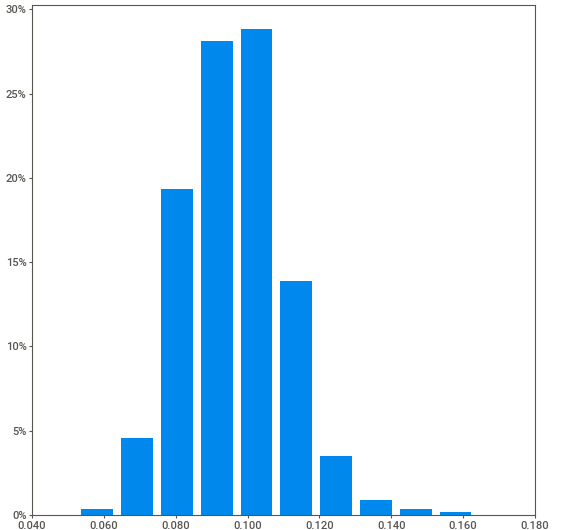
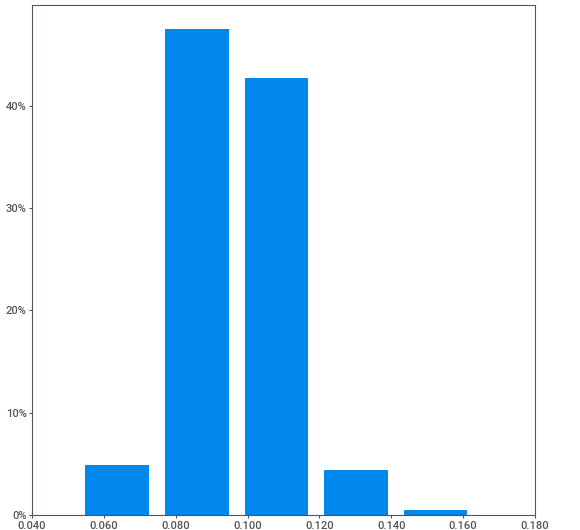
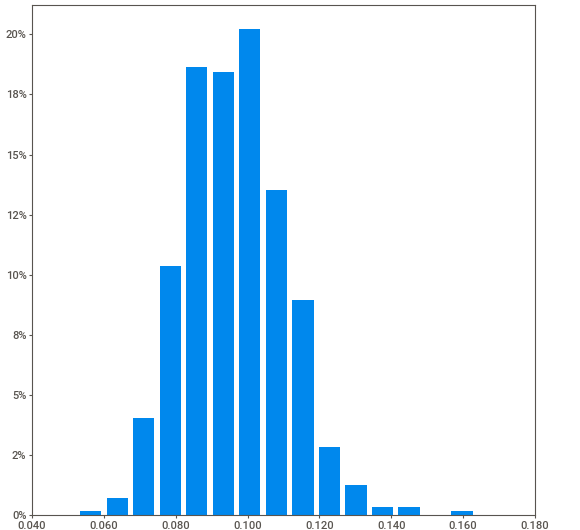
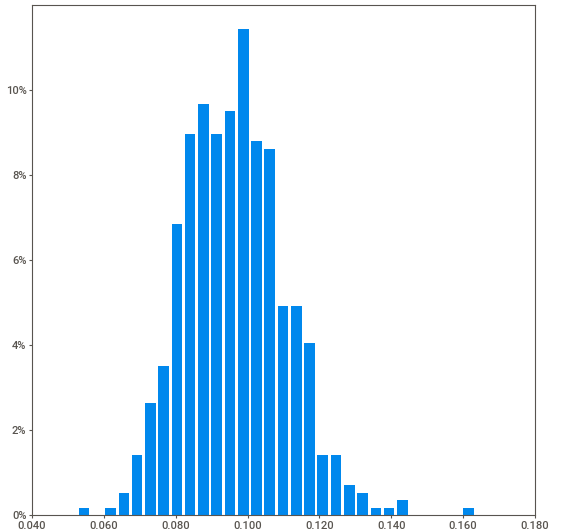
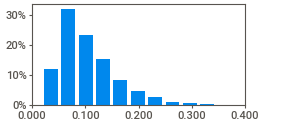
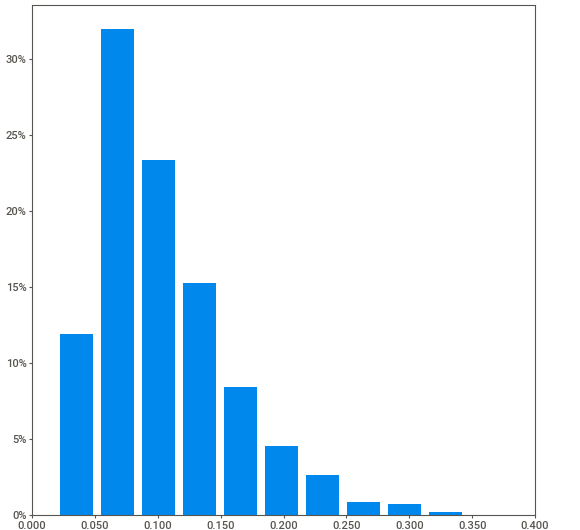
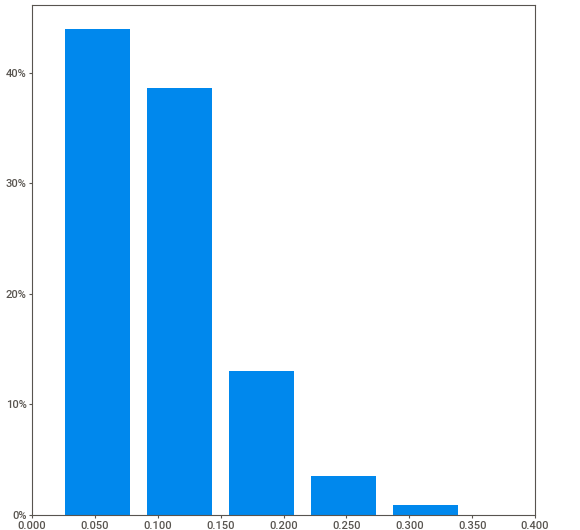
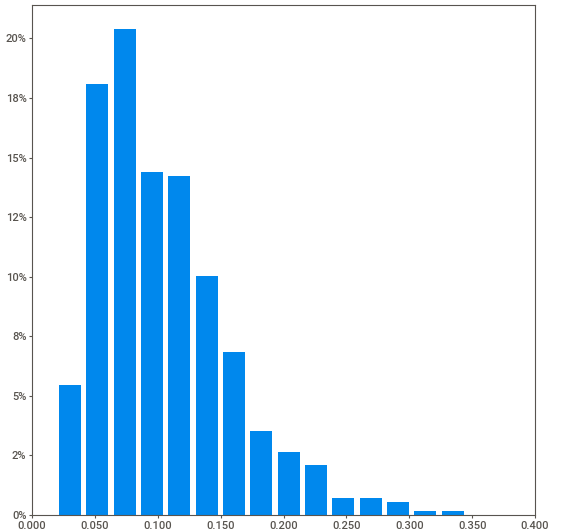
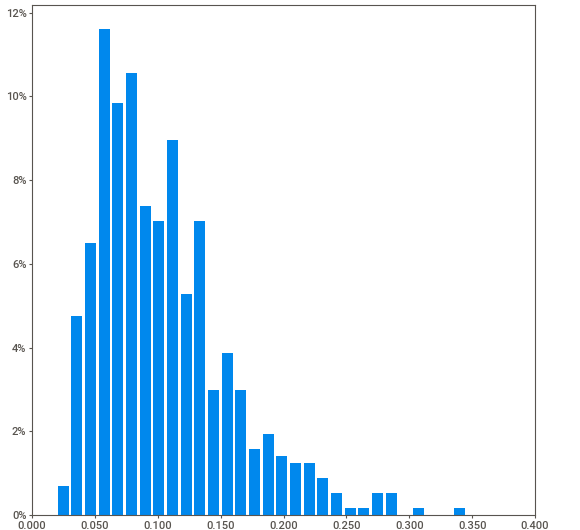
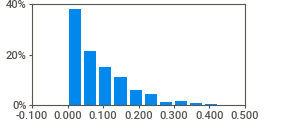
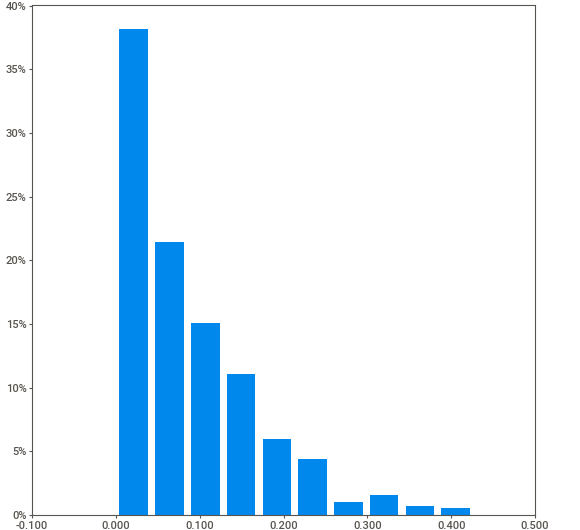
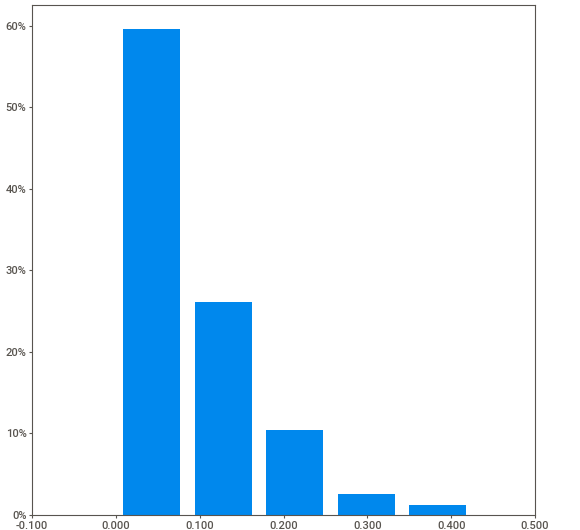
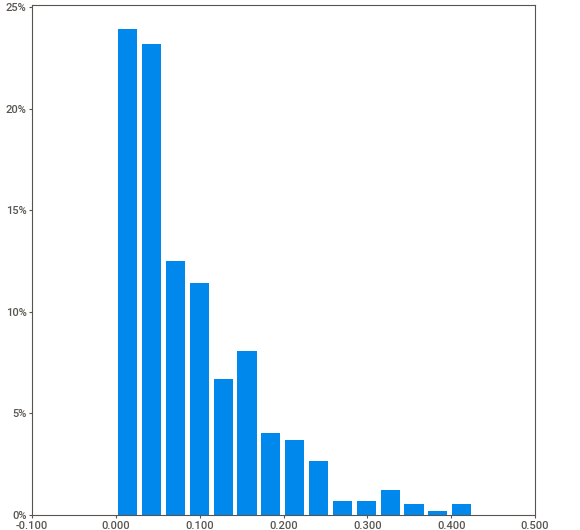
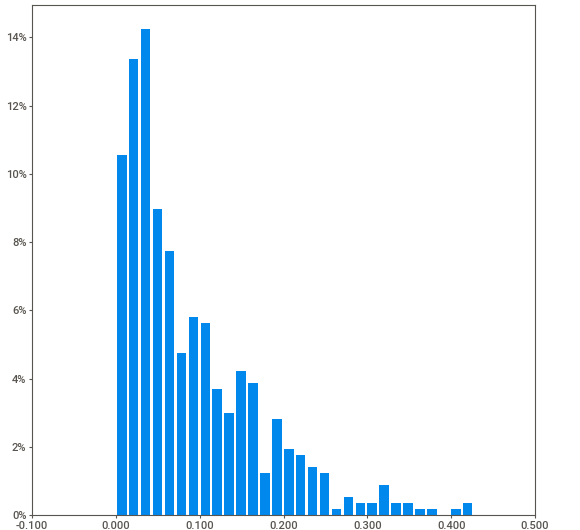
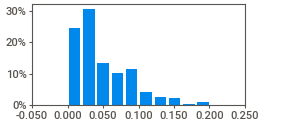
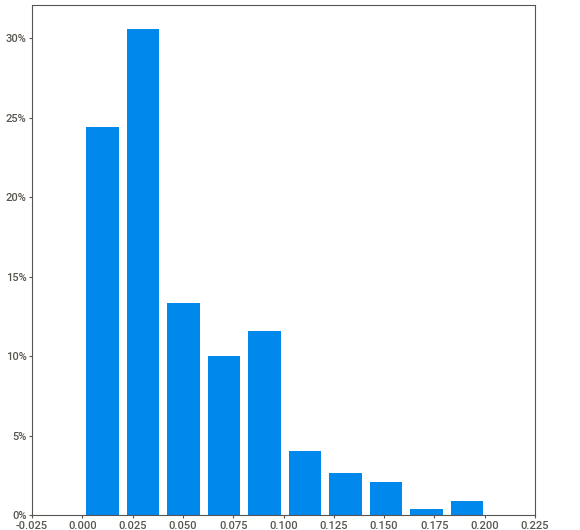
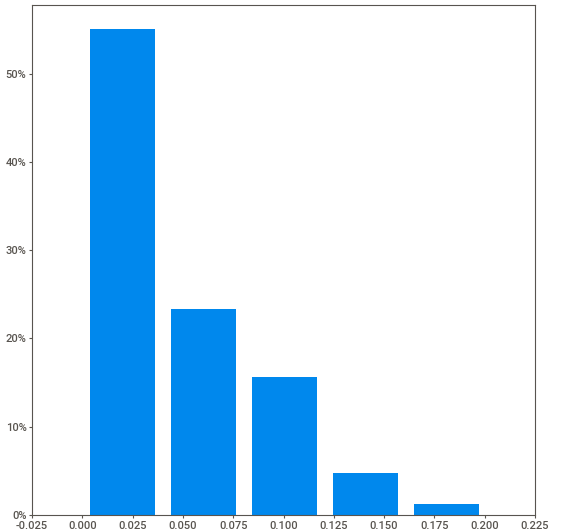
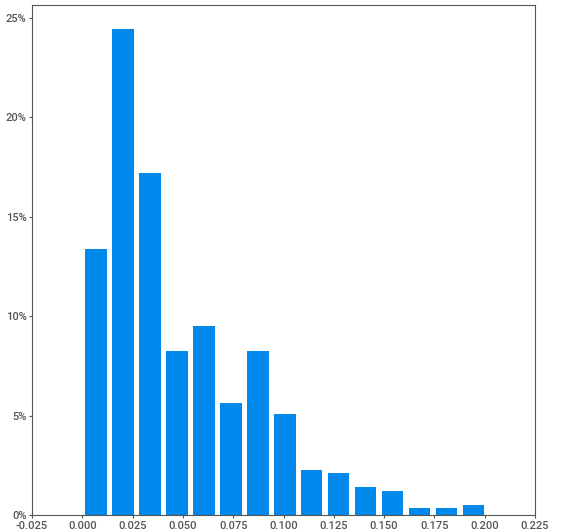
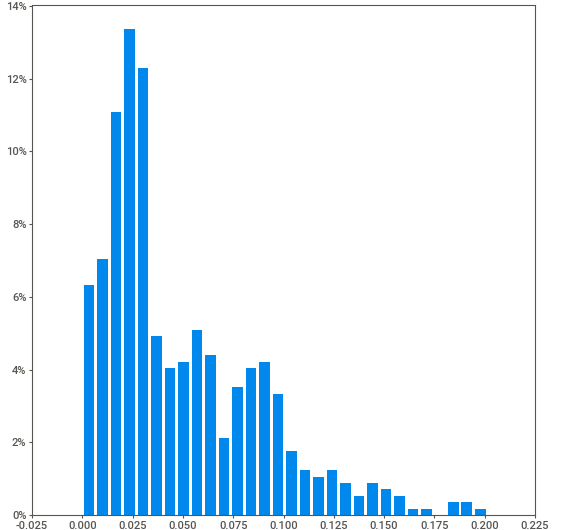
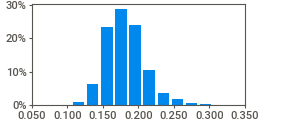
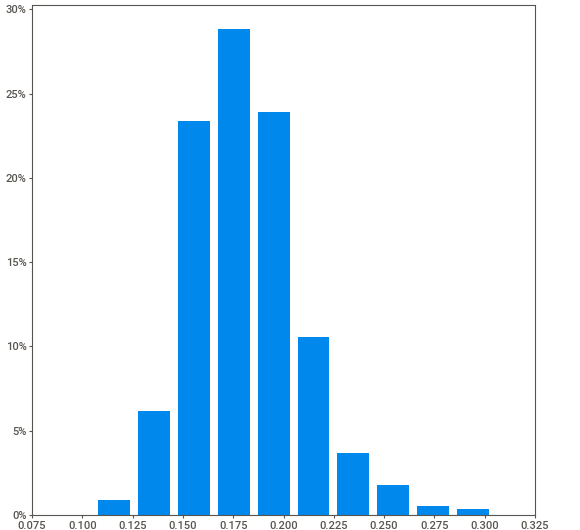
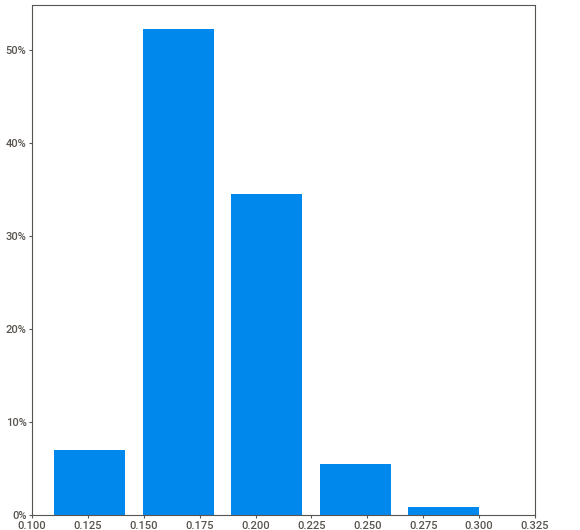
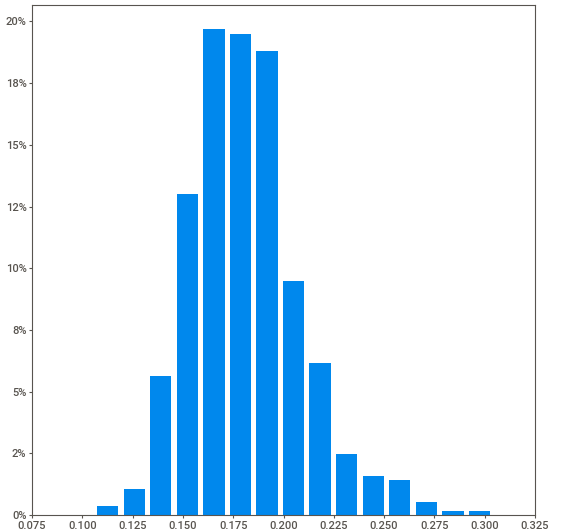
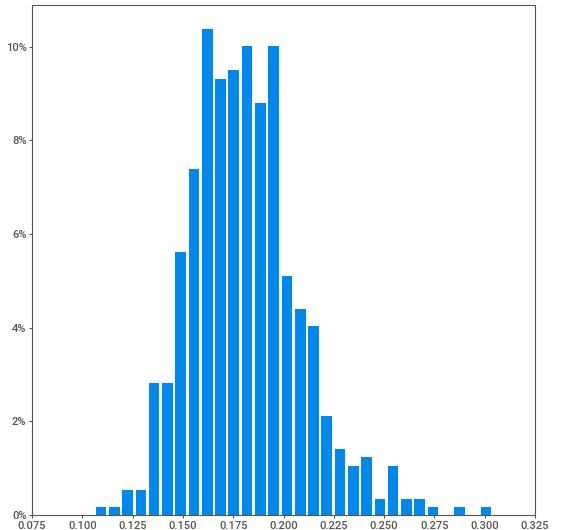
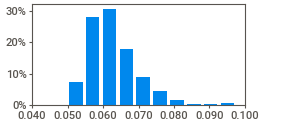
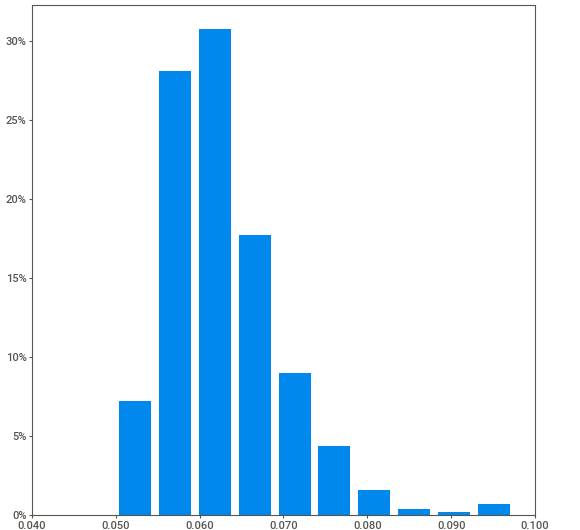
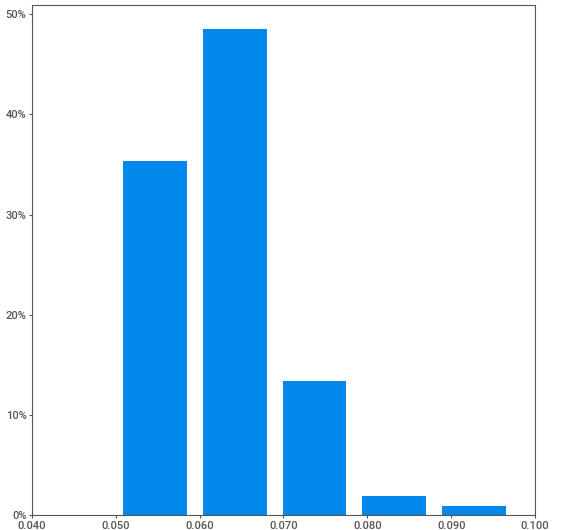
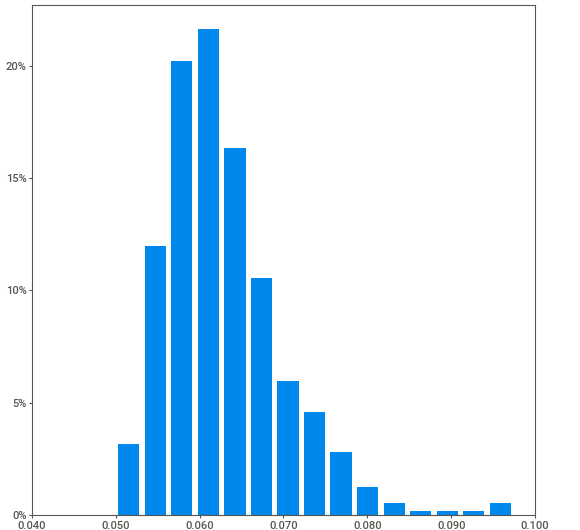
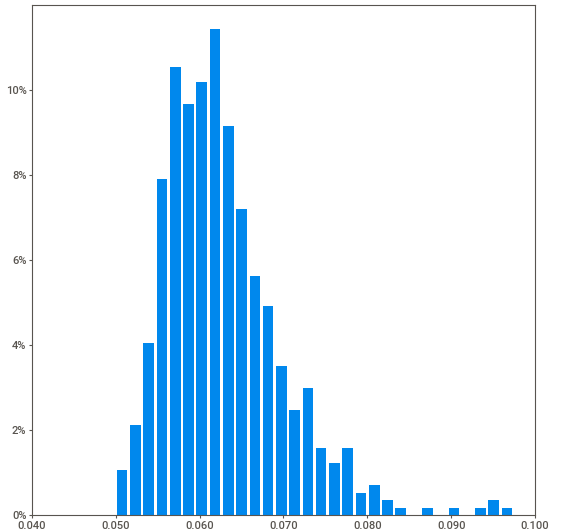
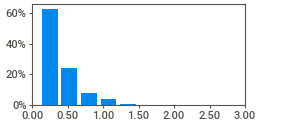
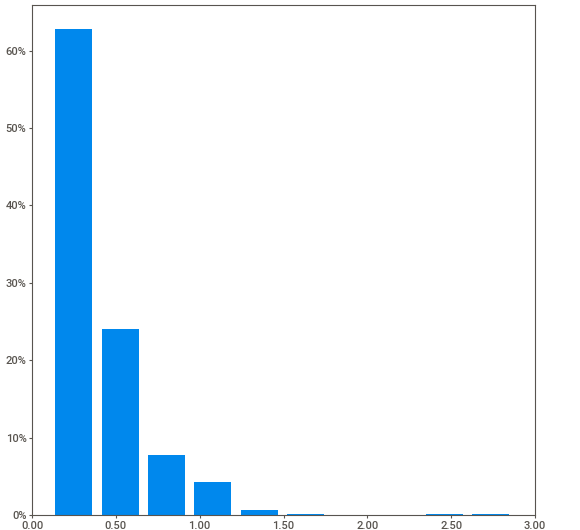
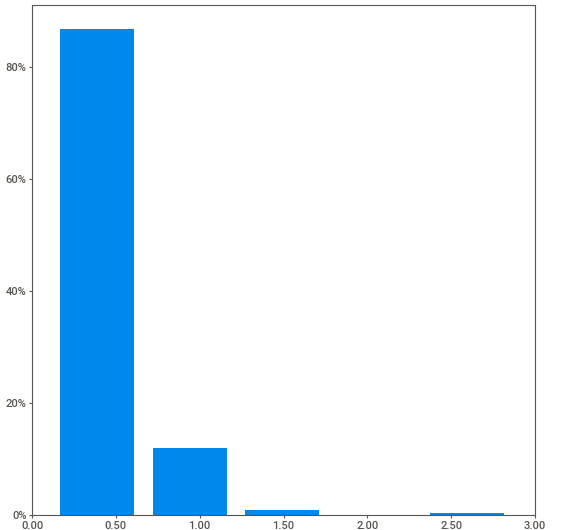
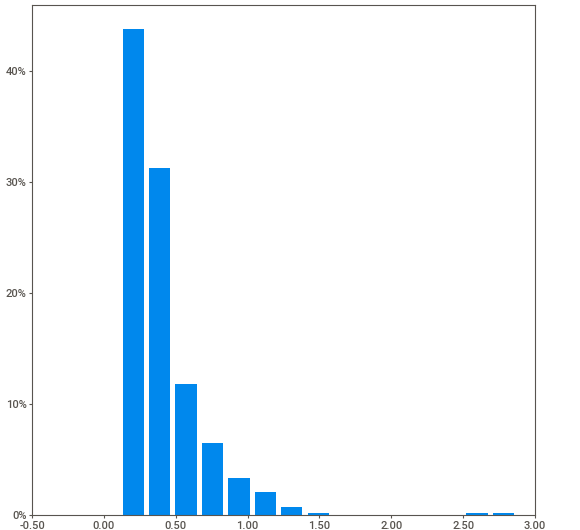
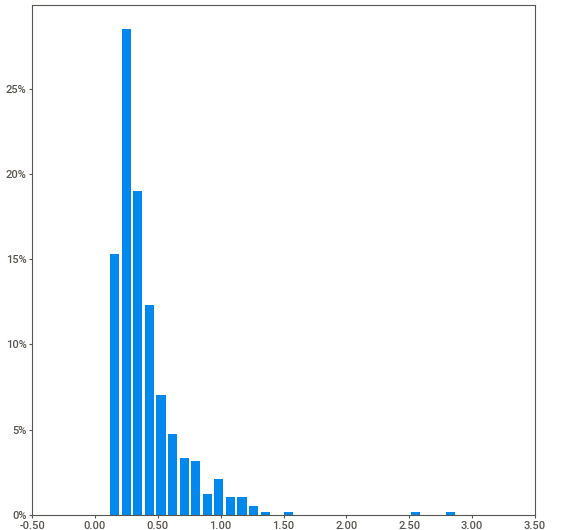
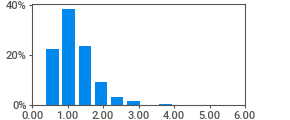
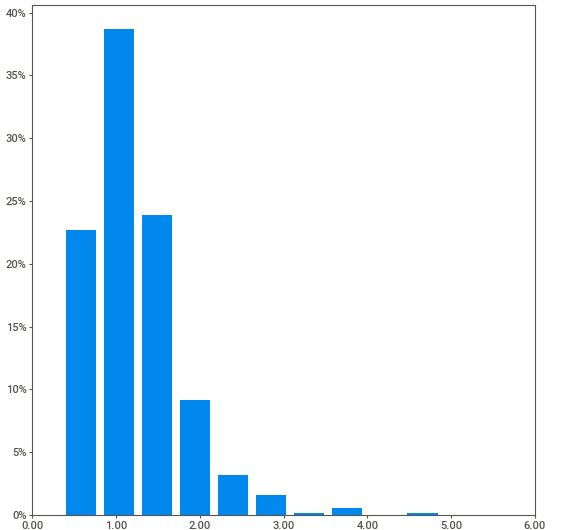
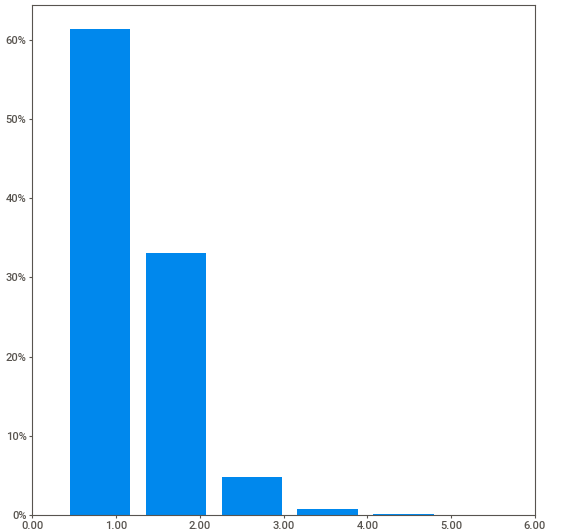
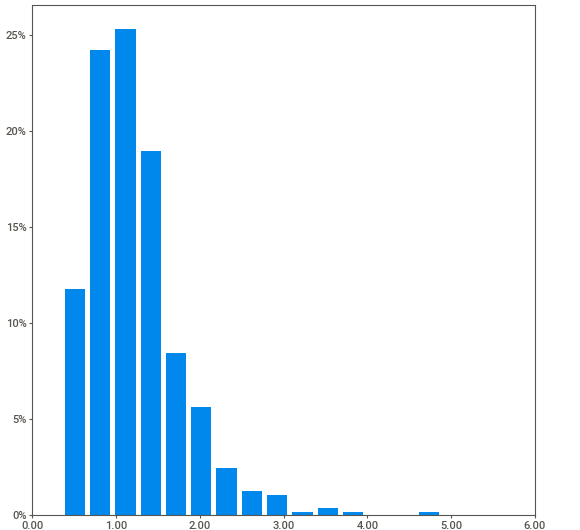
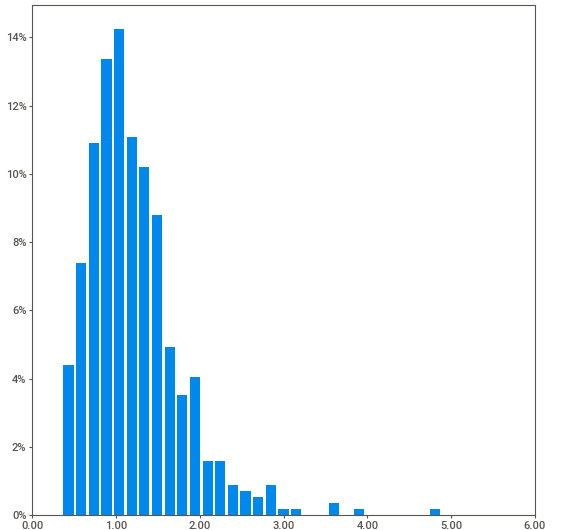
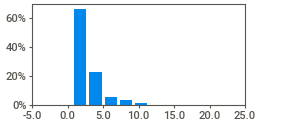
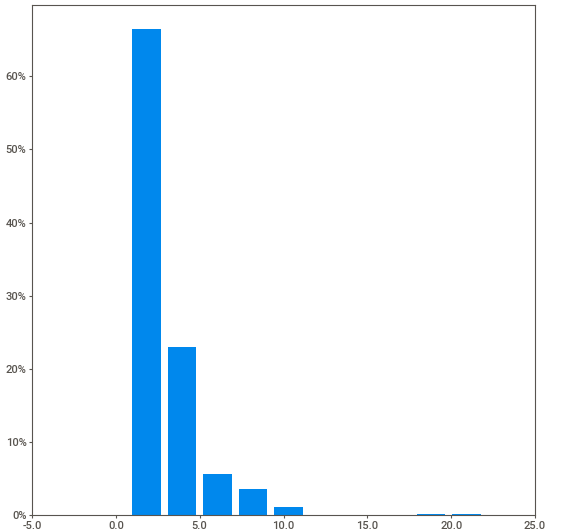
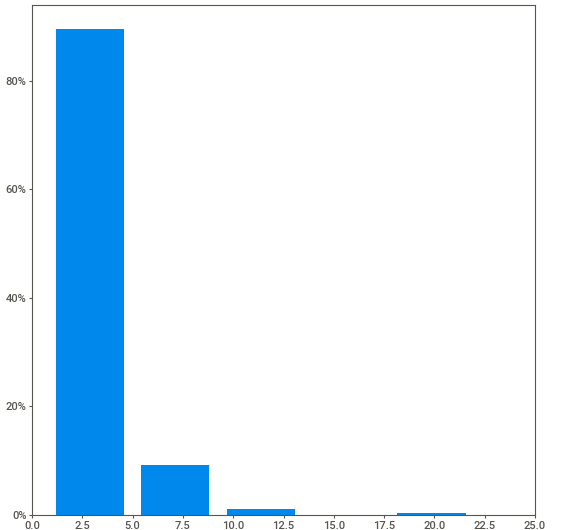
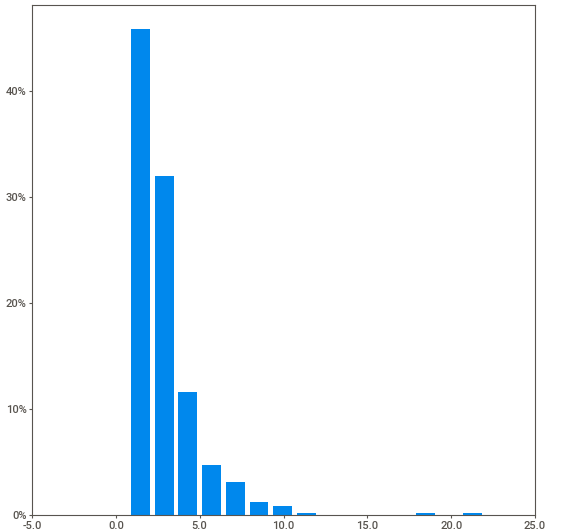
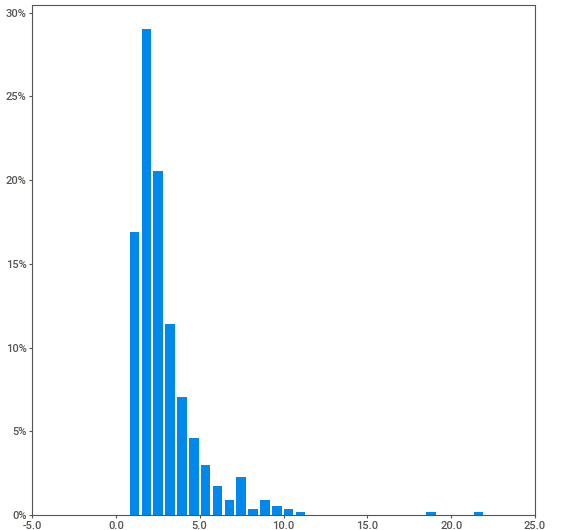
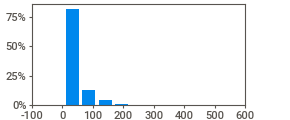
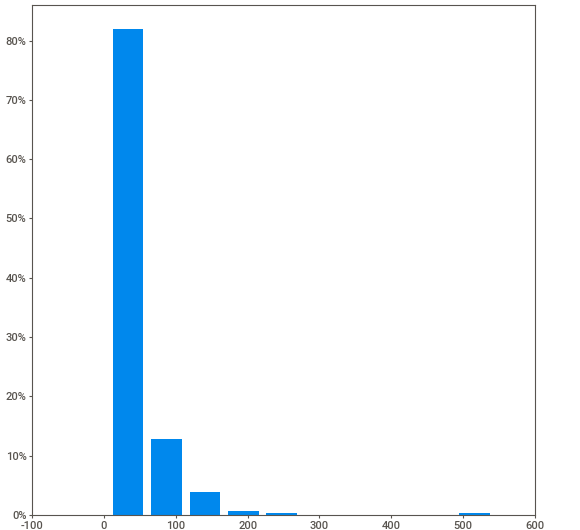
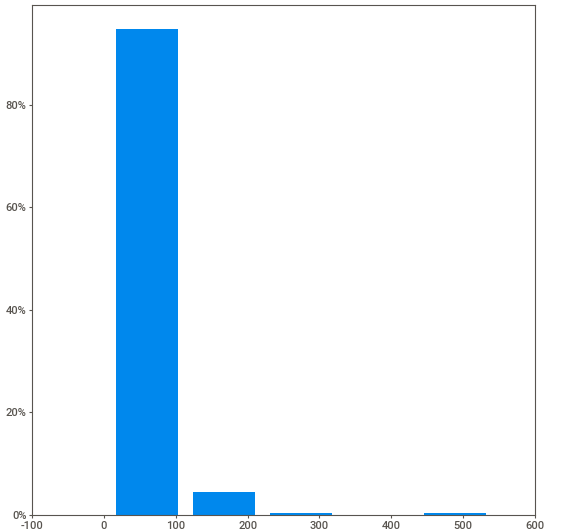
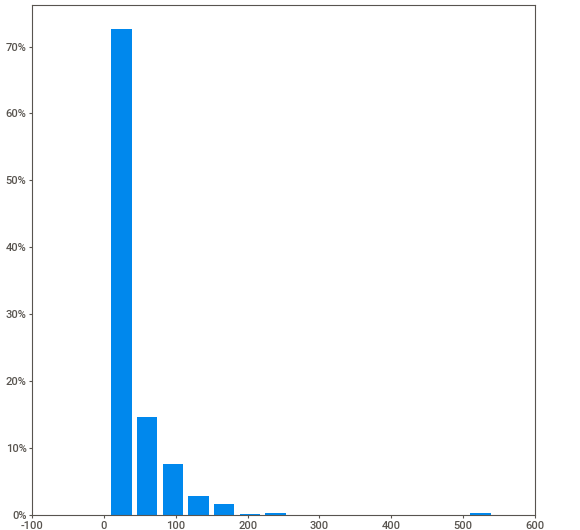
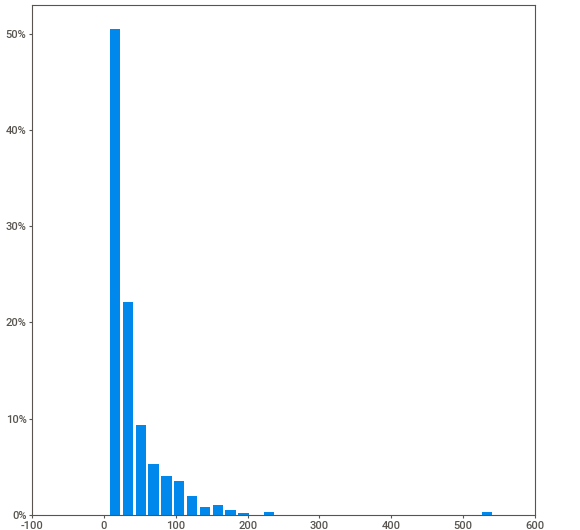
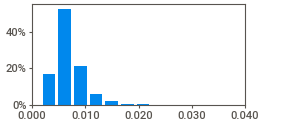
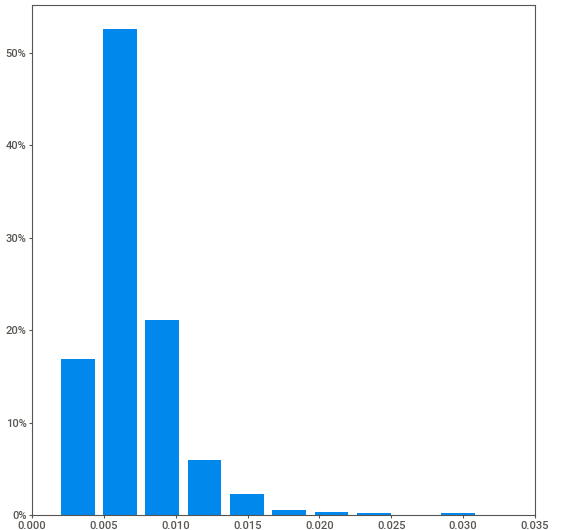
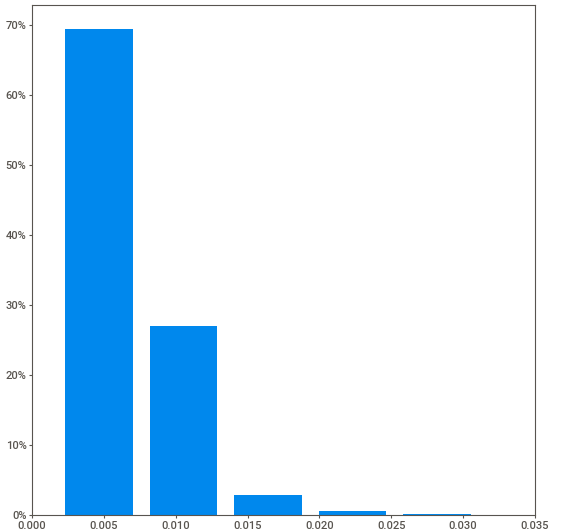
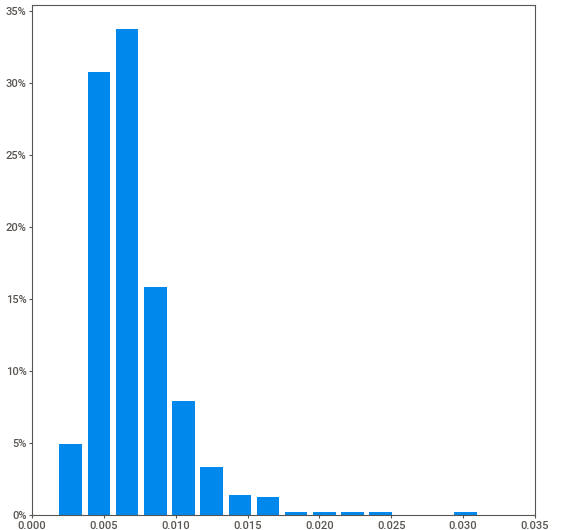
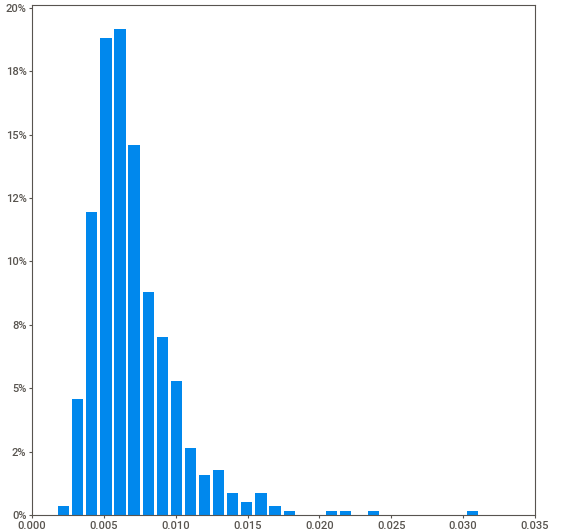
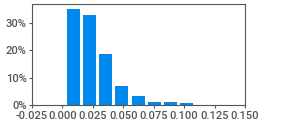
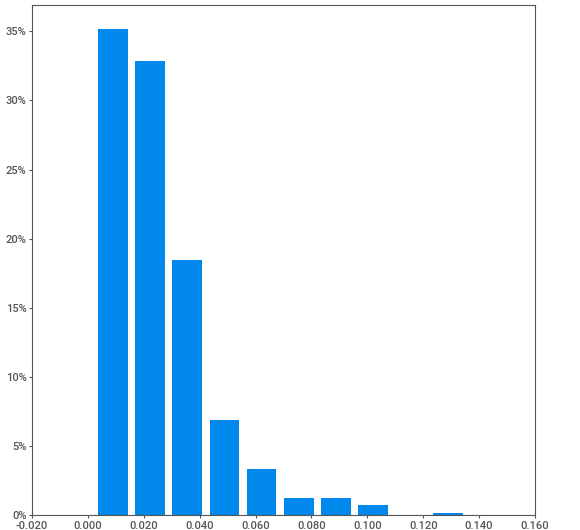
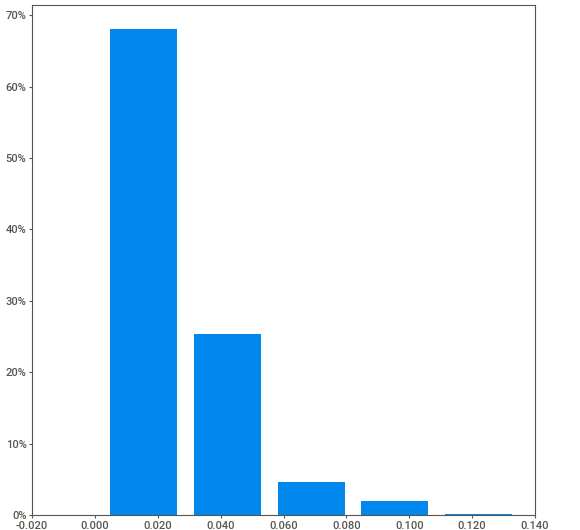
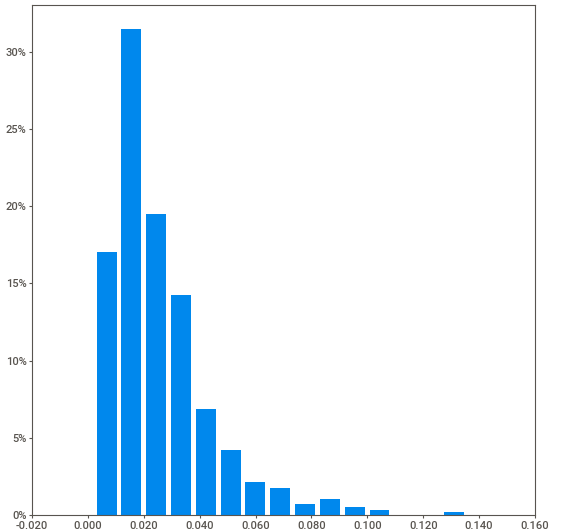
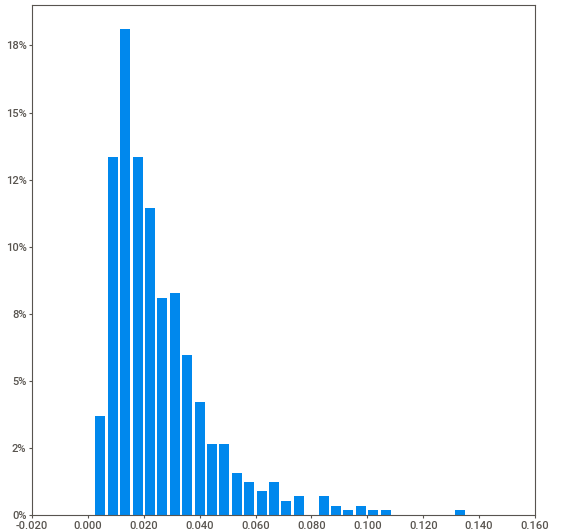
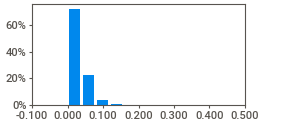
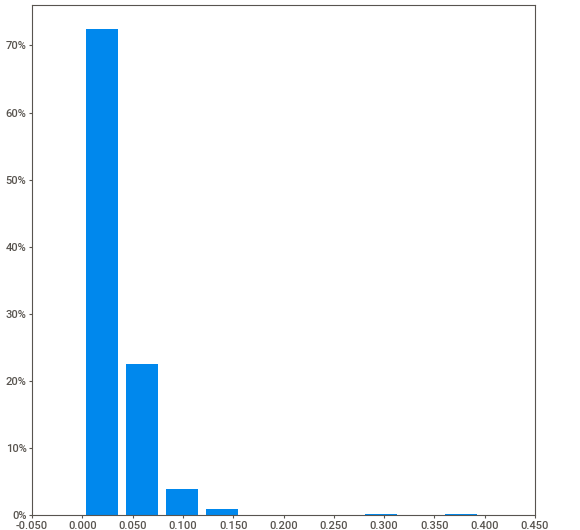
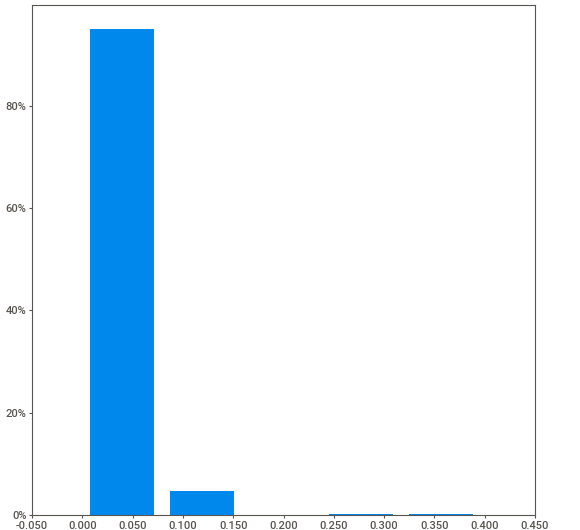
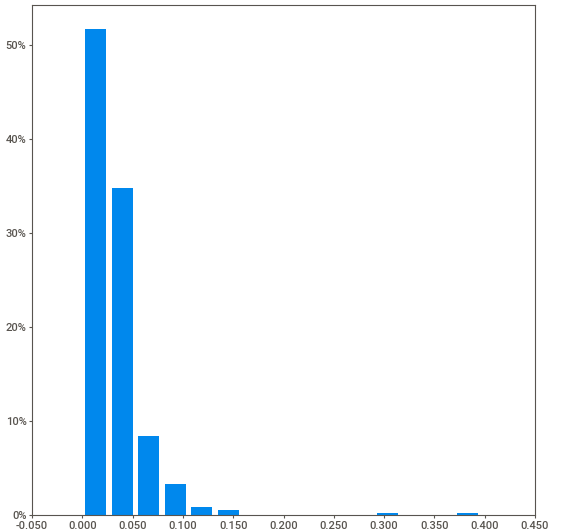
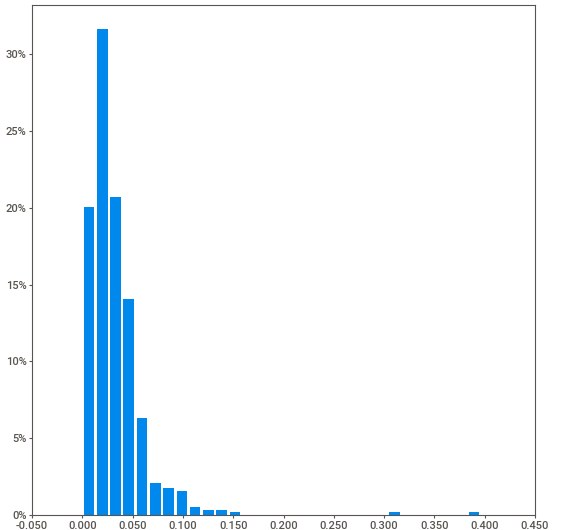
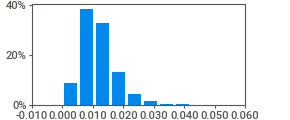
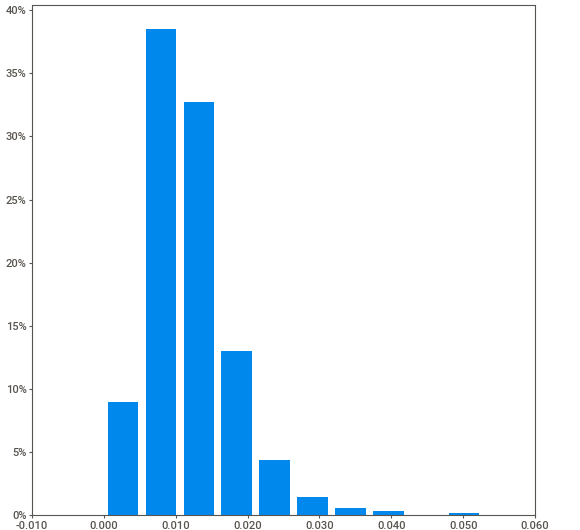
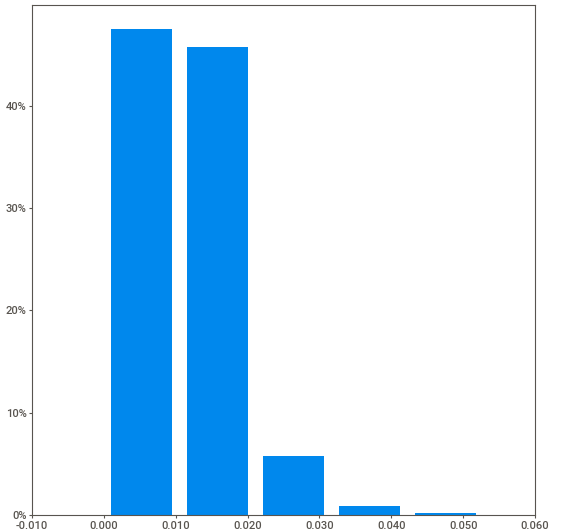
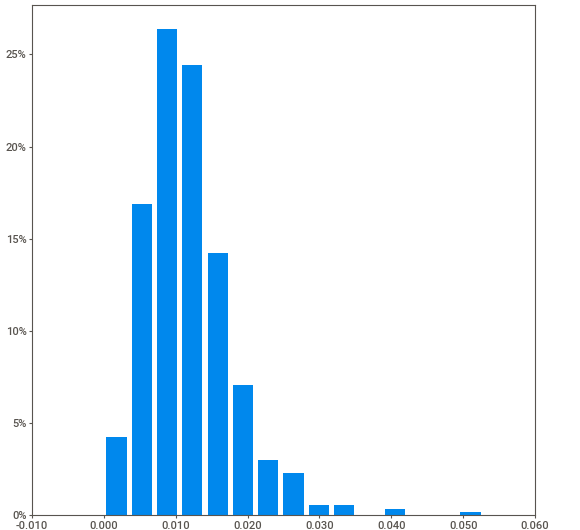
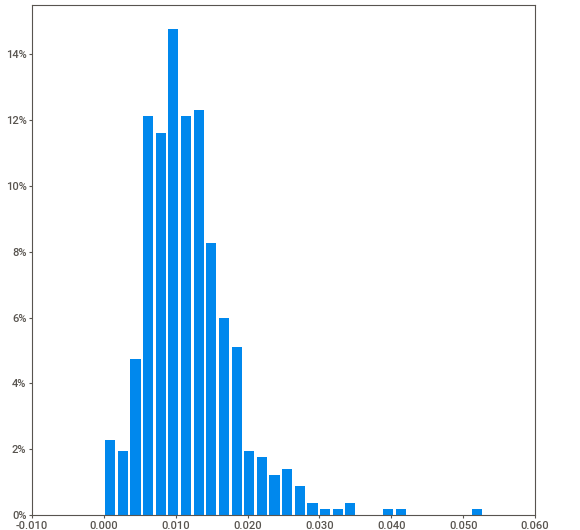
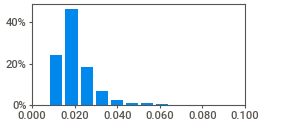
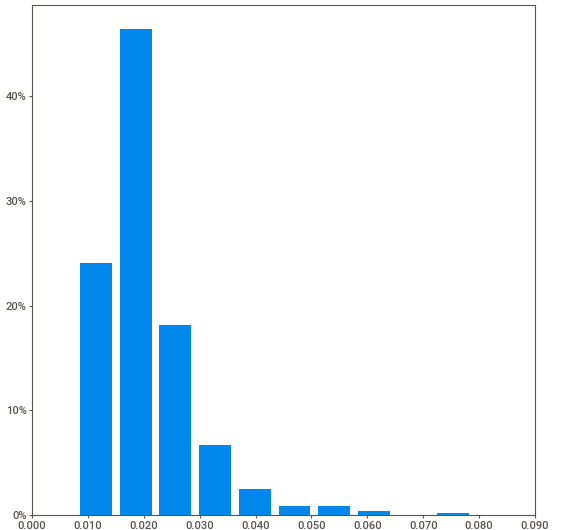
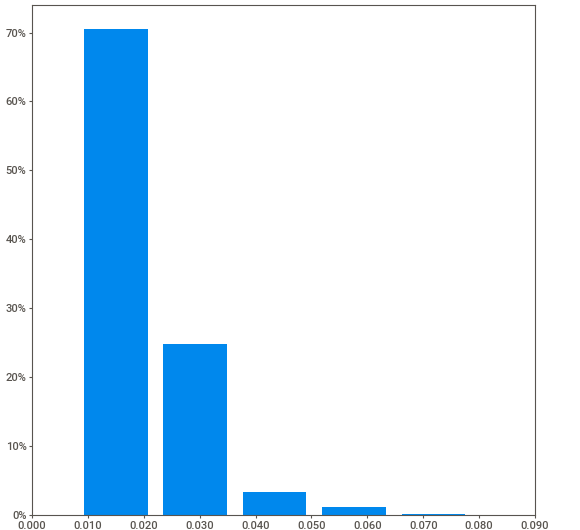
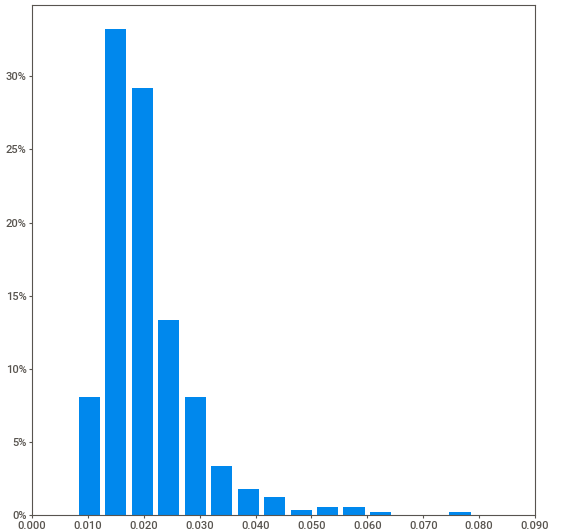
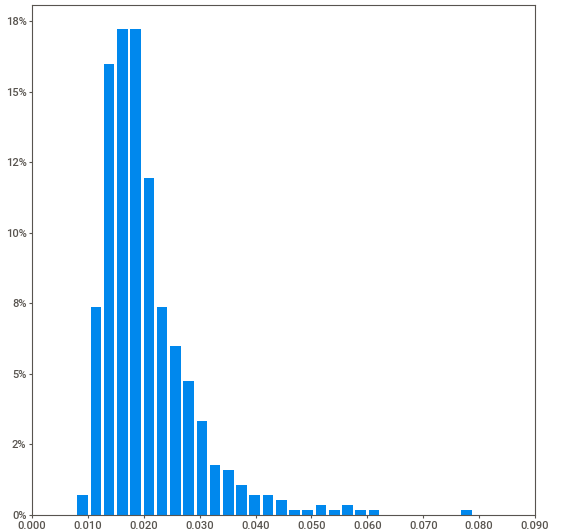
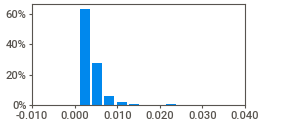
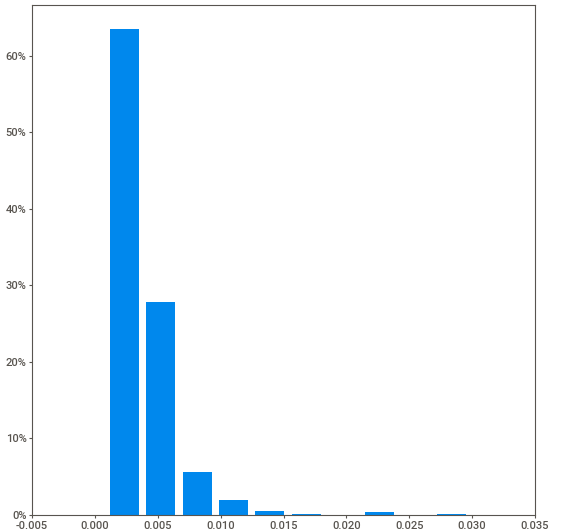
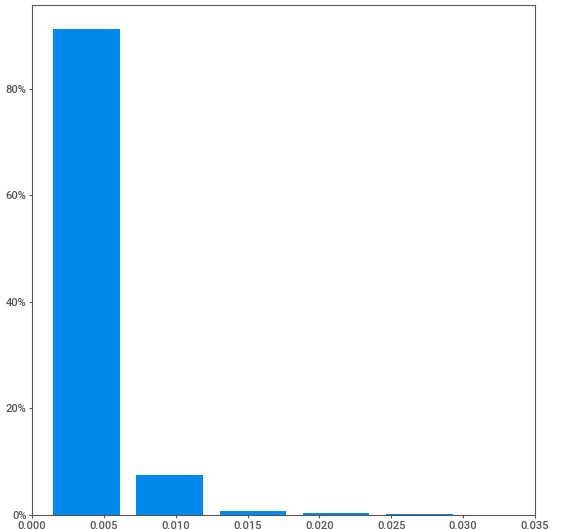
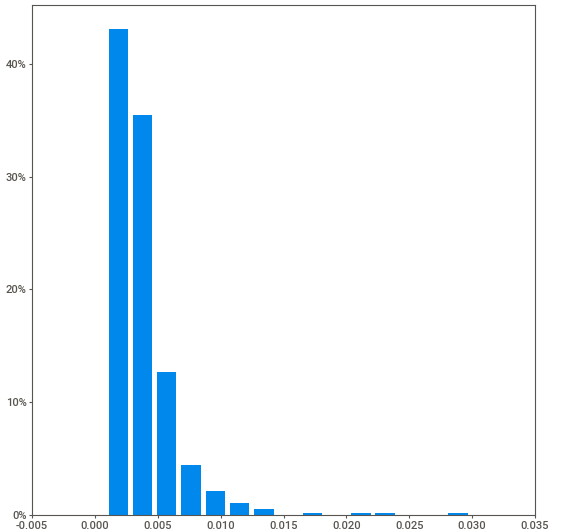
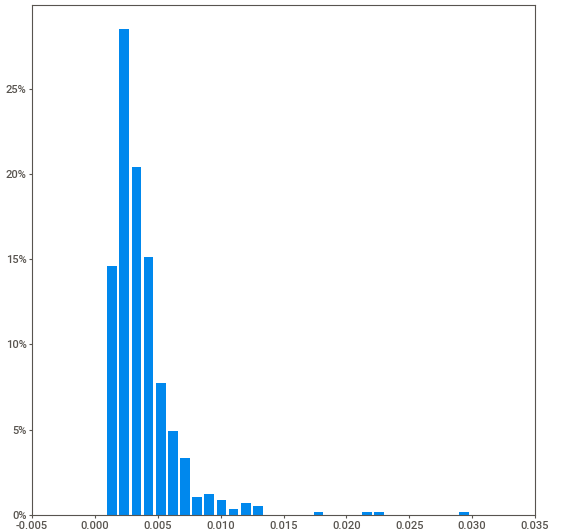
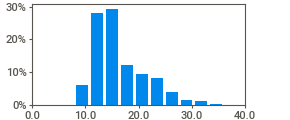
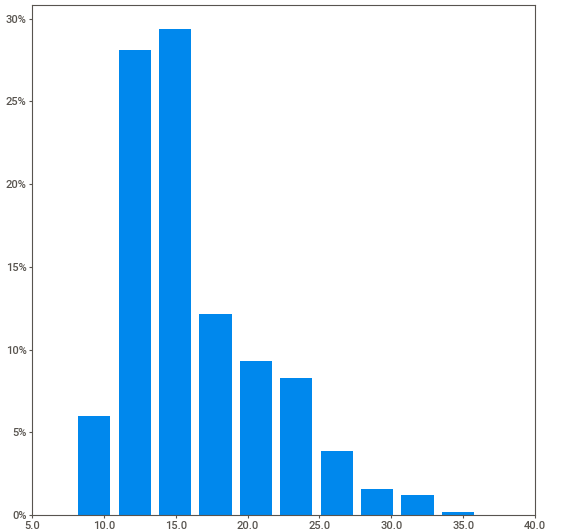
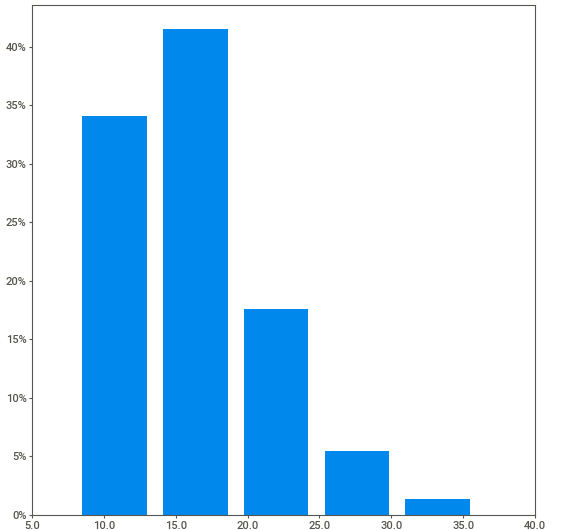
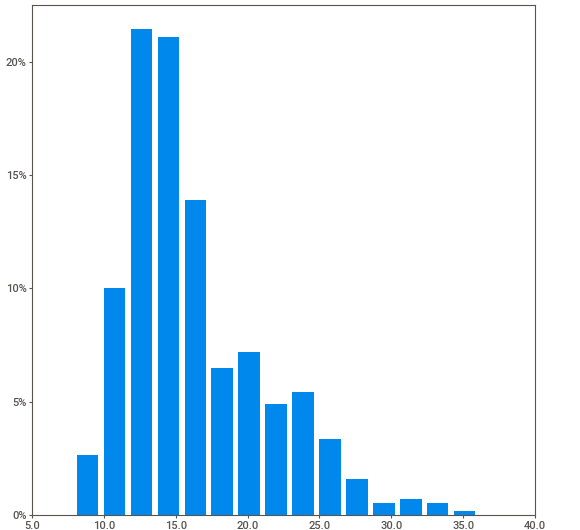
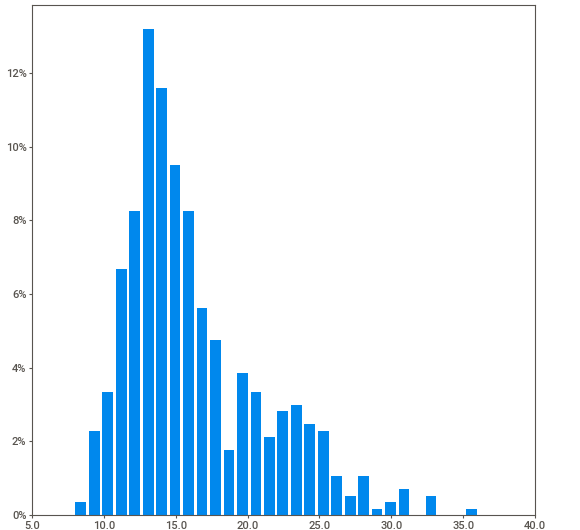
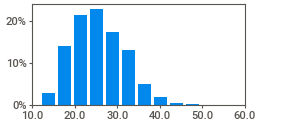
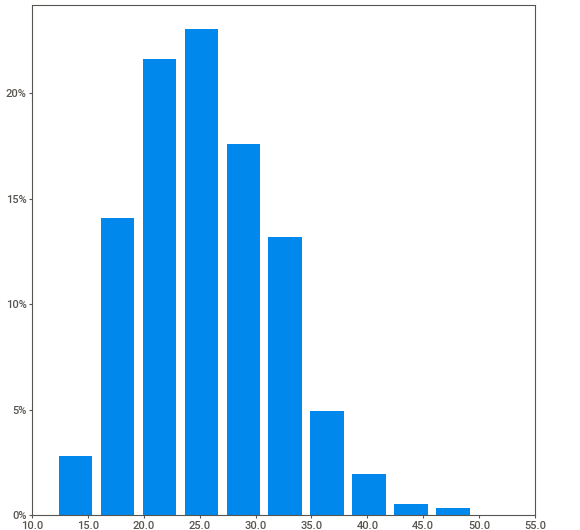
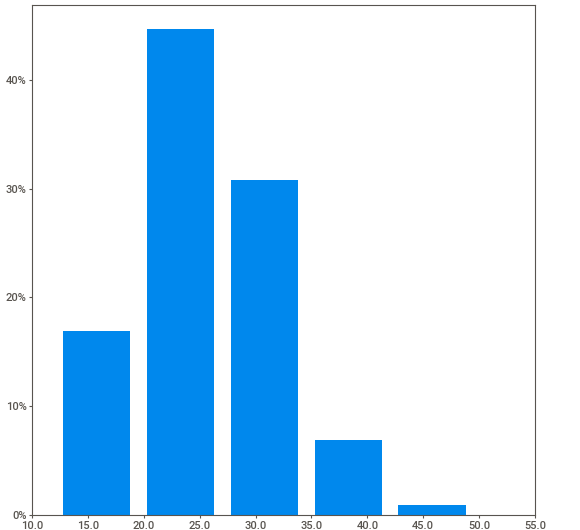
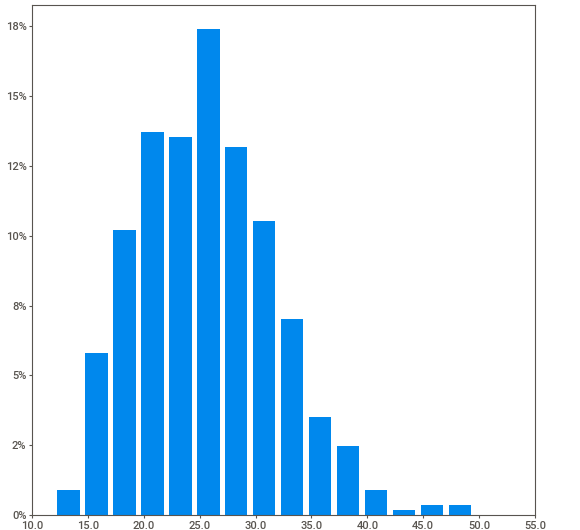
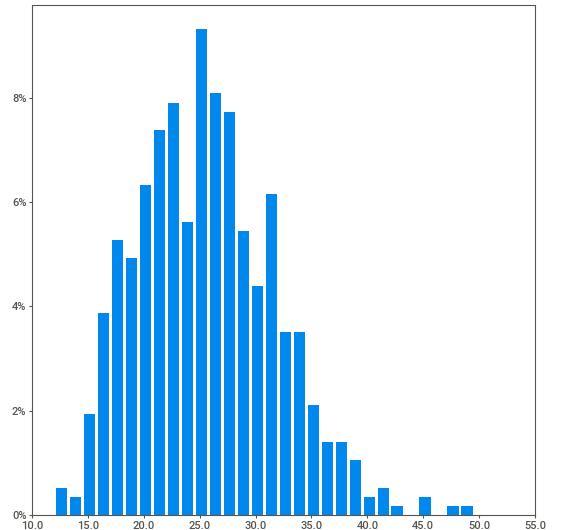
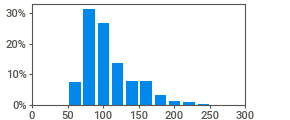
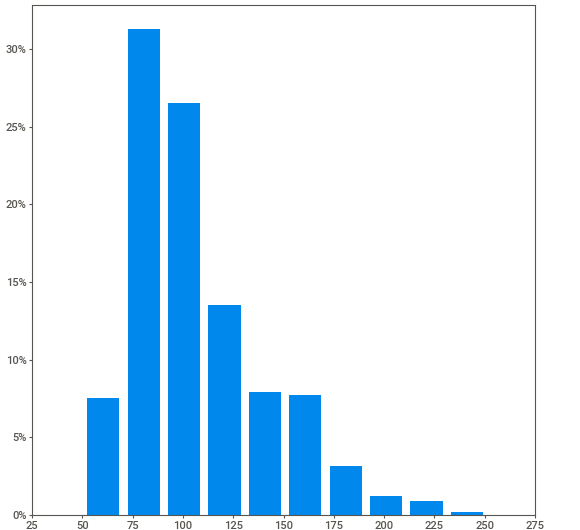
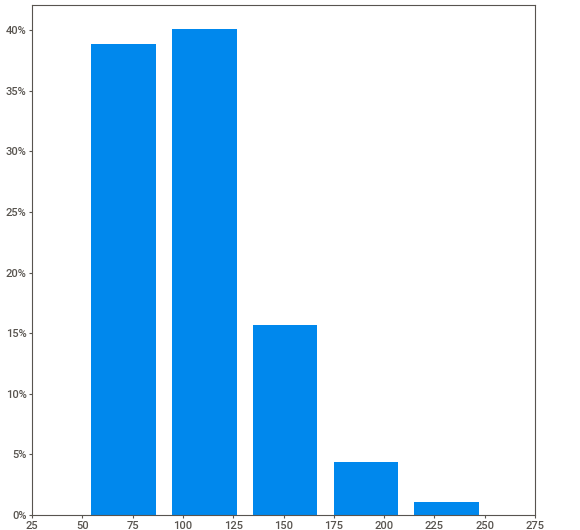
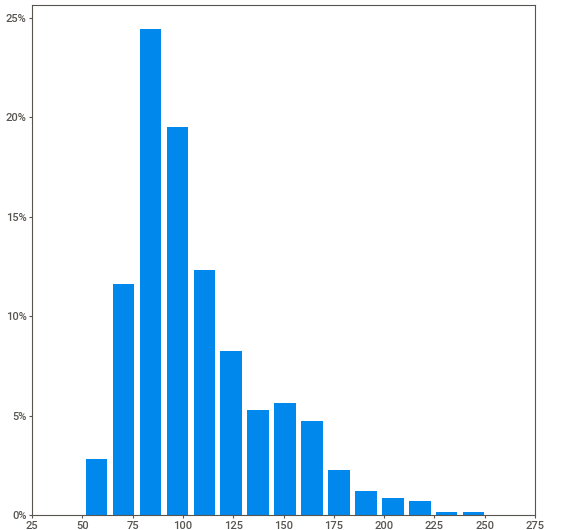
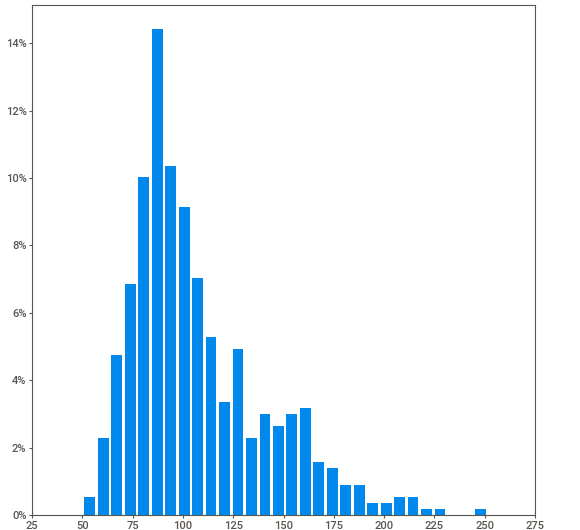
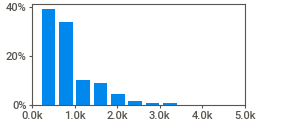
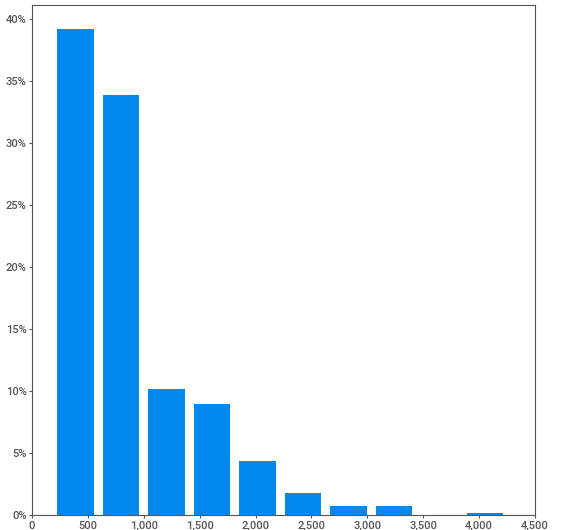
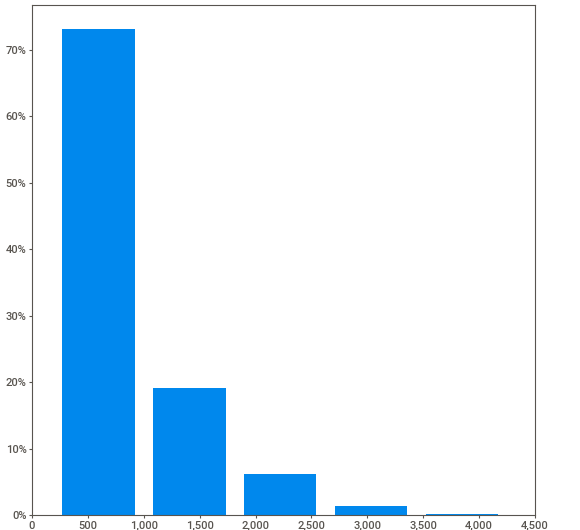
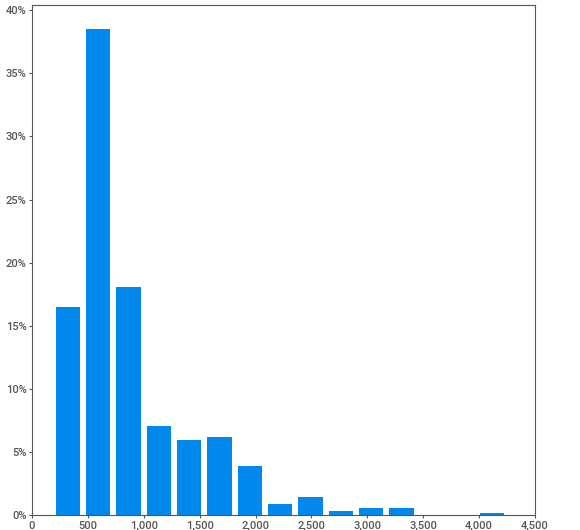
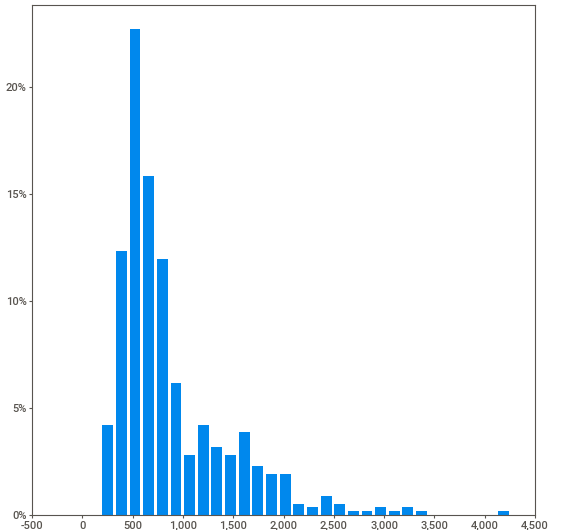
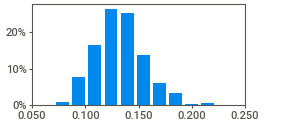
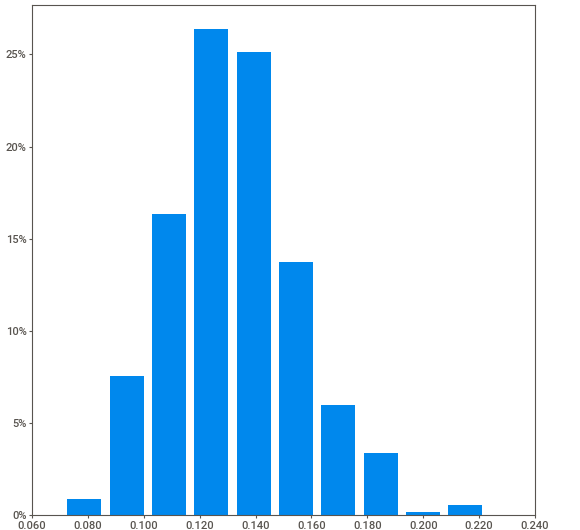
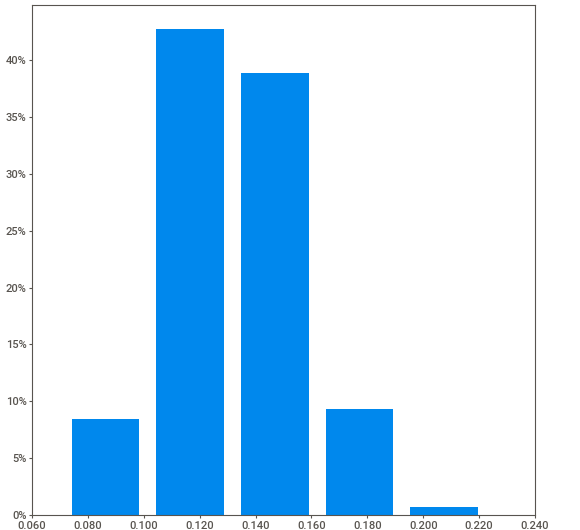
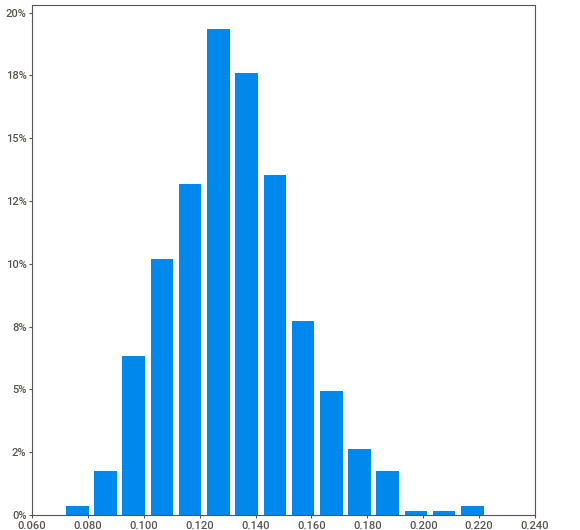
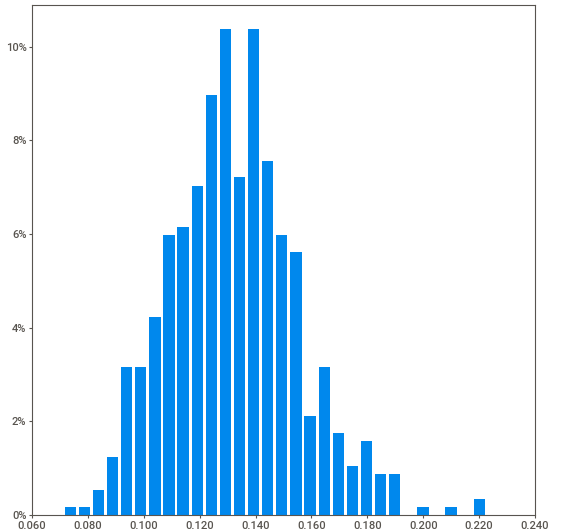
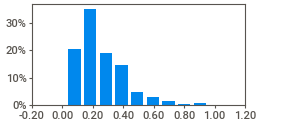
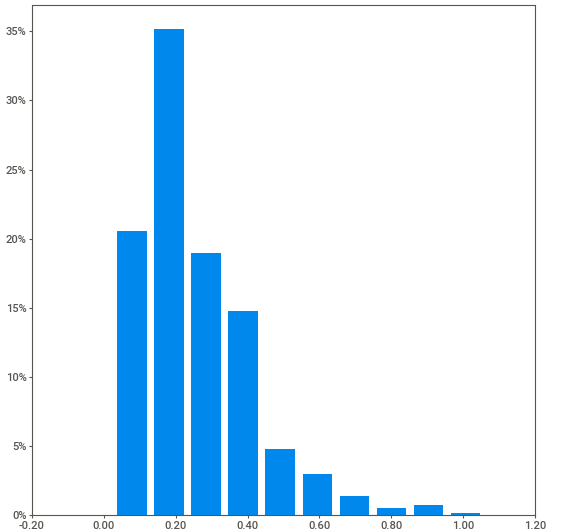
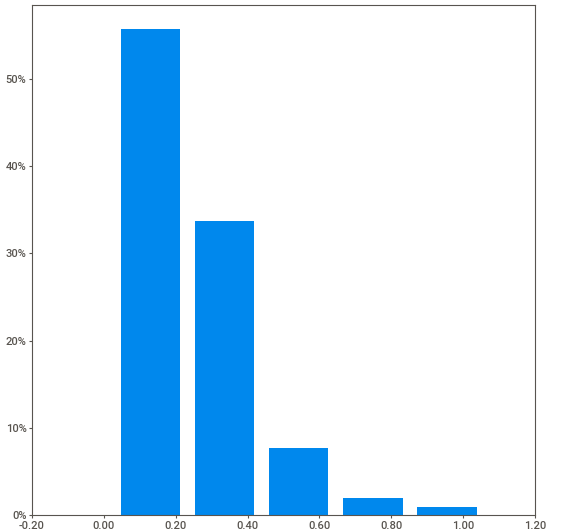
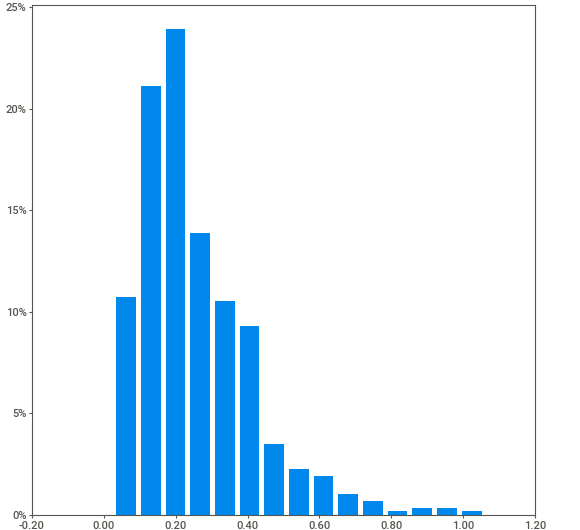
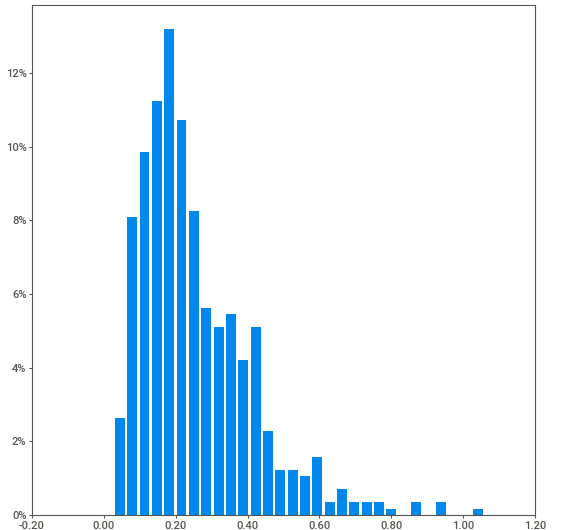
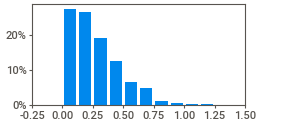
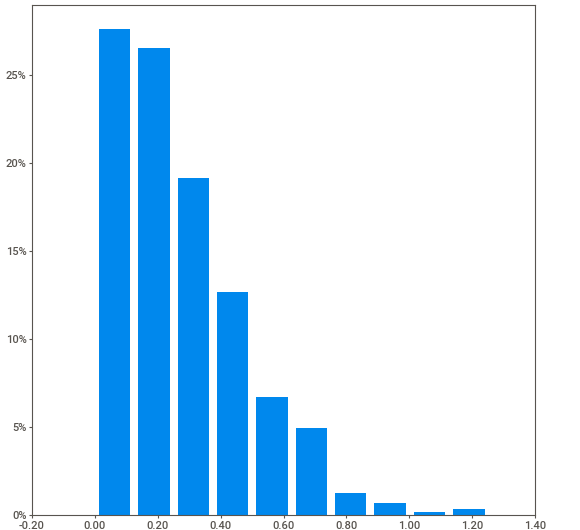
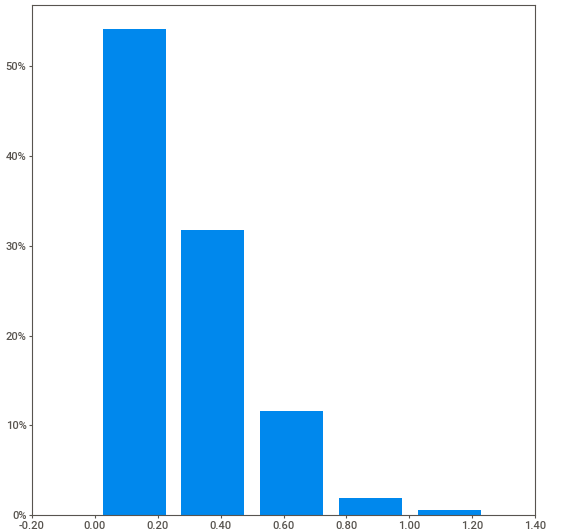
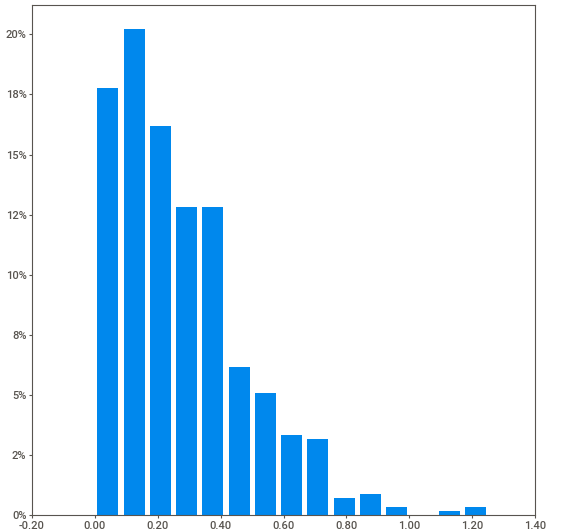
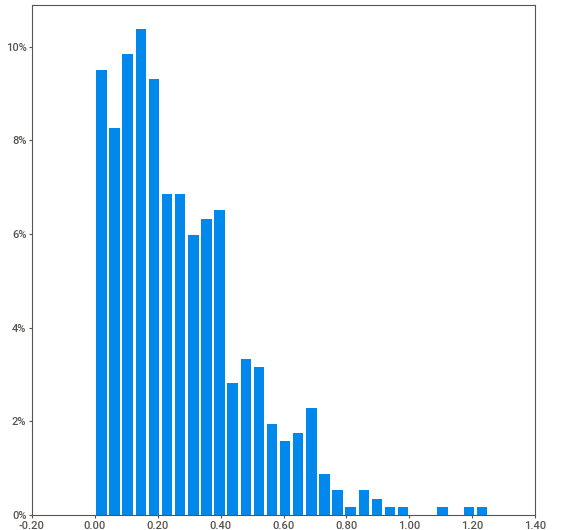
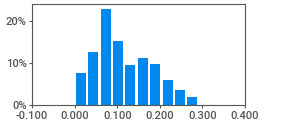
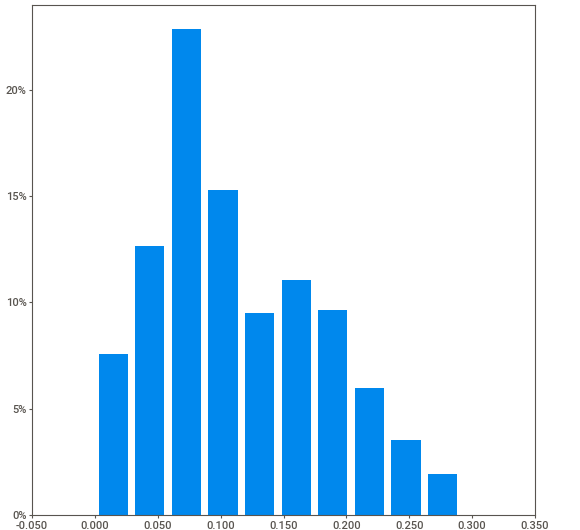
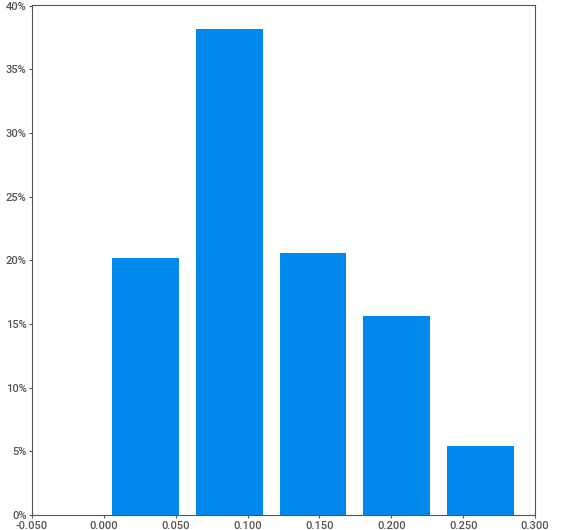
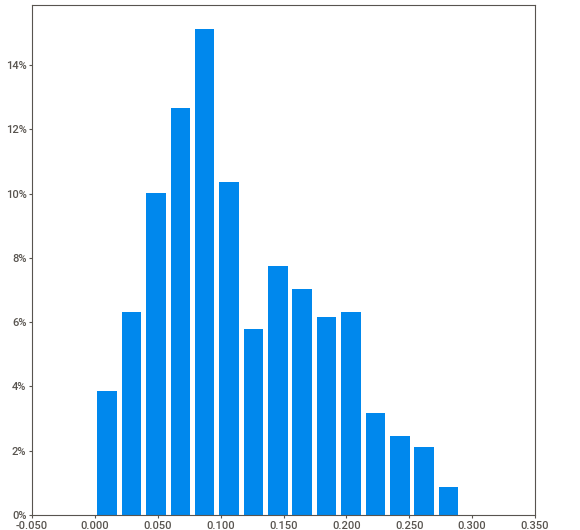
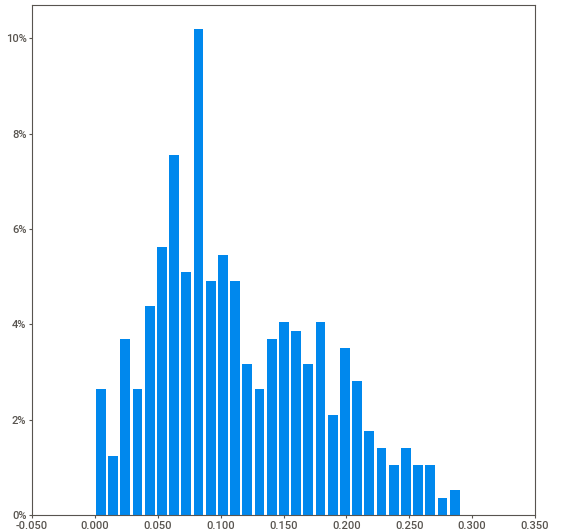
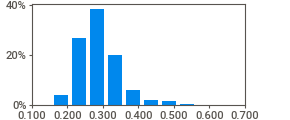
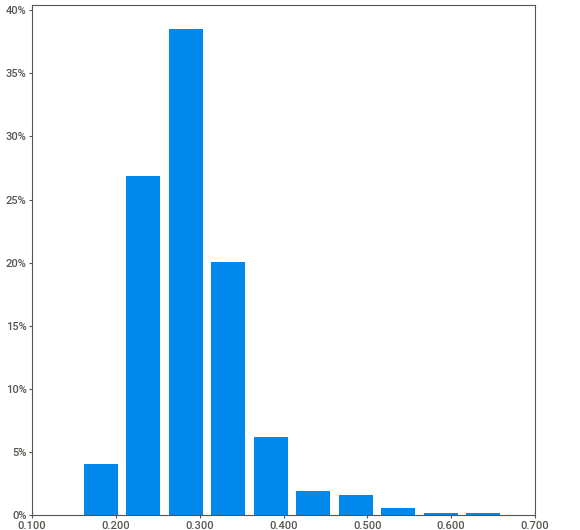
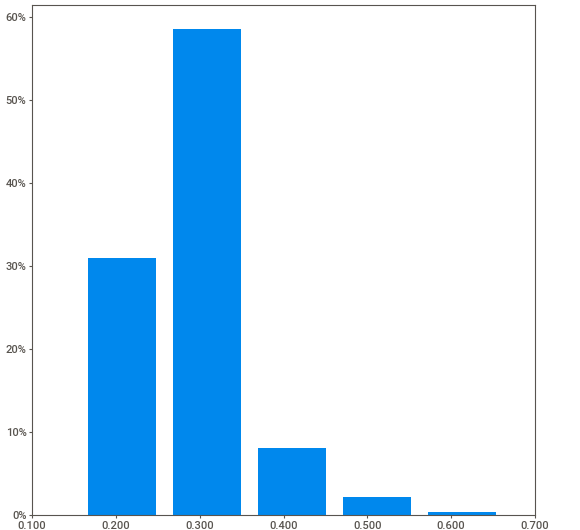
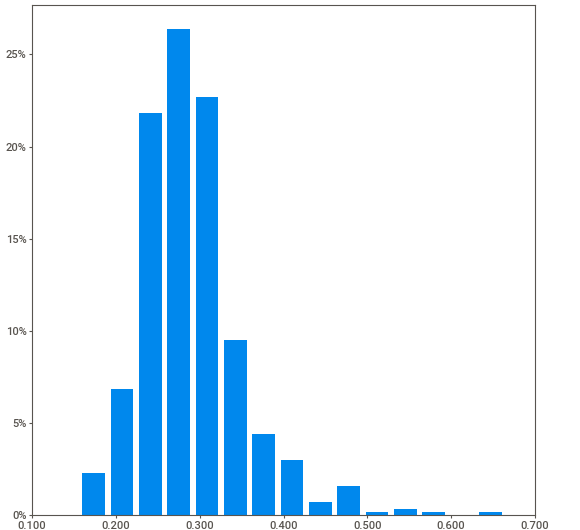
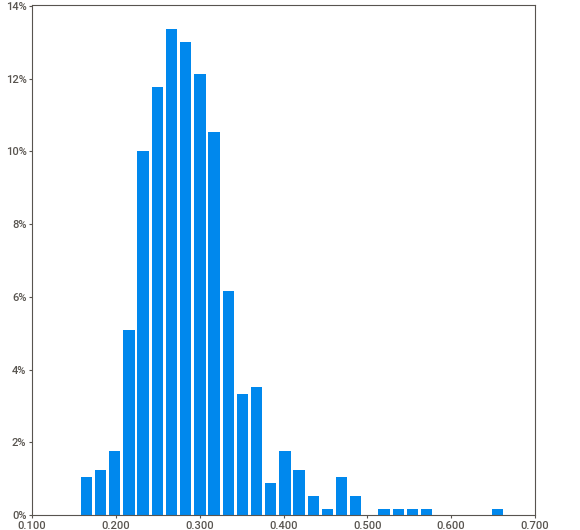
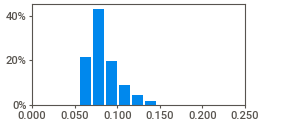
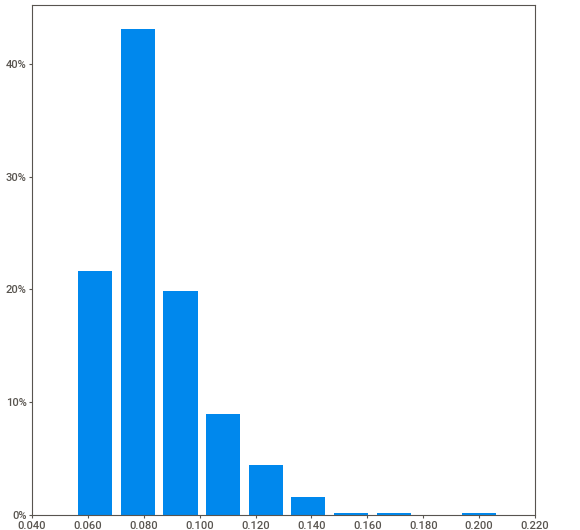
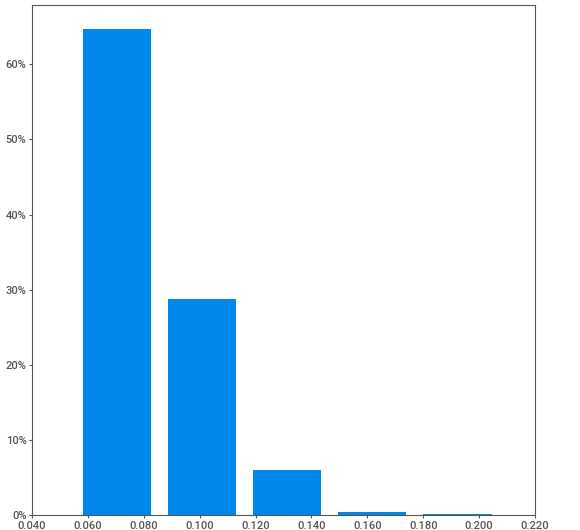
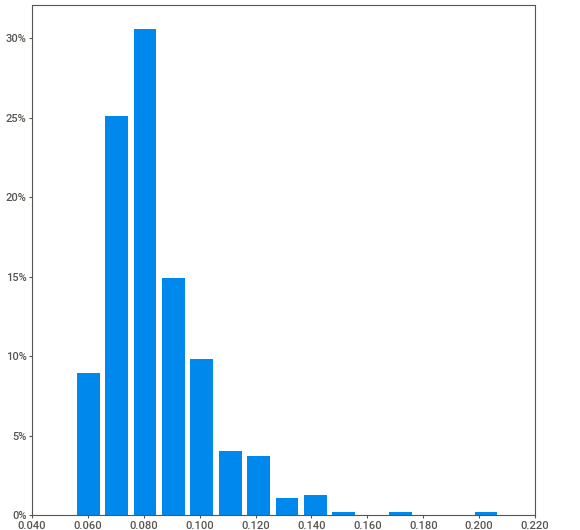
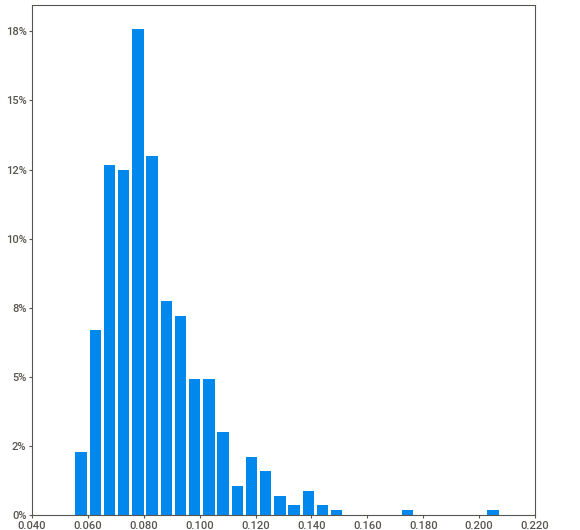
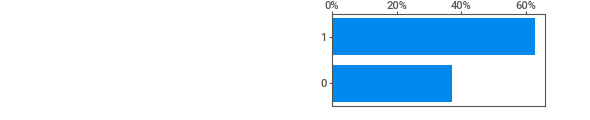
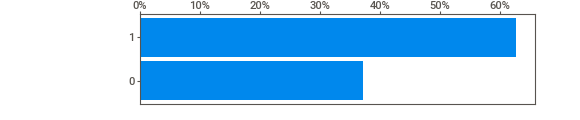
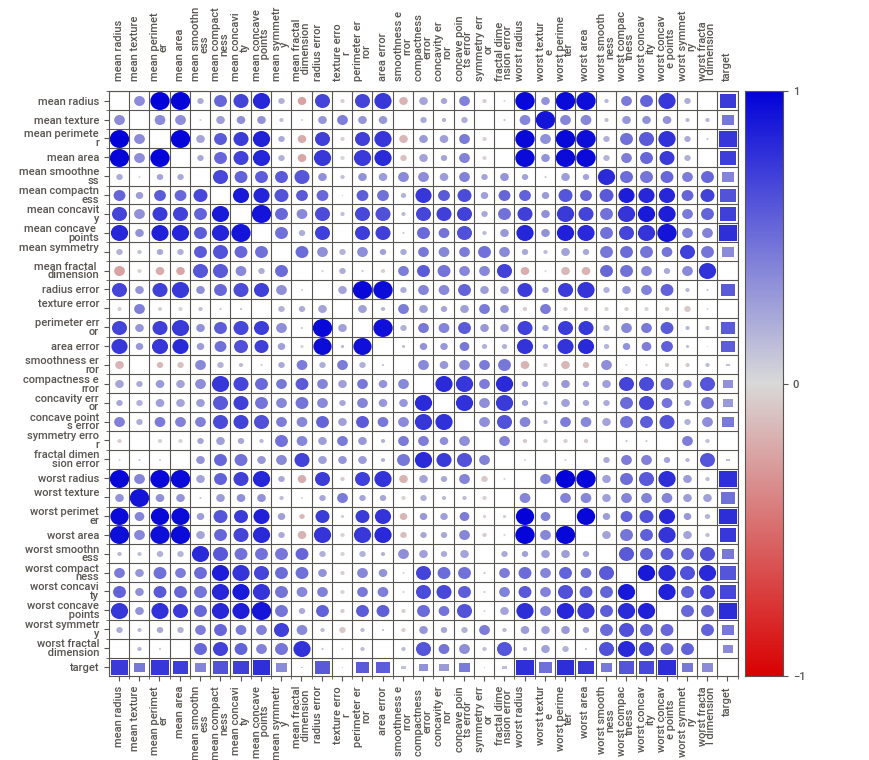
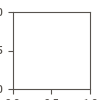

In [4]:
import sweetviz as sv

eda_report = sv.analyze(df)
eda_report.show_notebook()

Being a multidimensional dataset and having variables with different distributions, a neural network is a valid option to model this data. That said, this dataset can also be modeled by simpler models, such as decision trees.

We will use PCA (Principal Component Analysis) from Sklearn and Seaborn to visualize the multidimensional dataset.

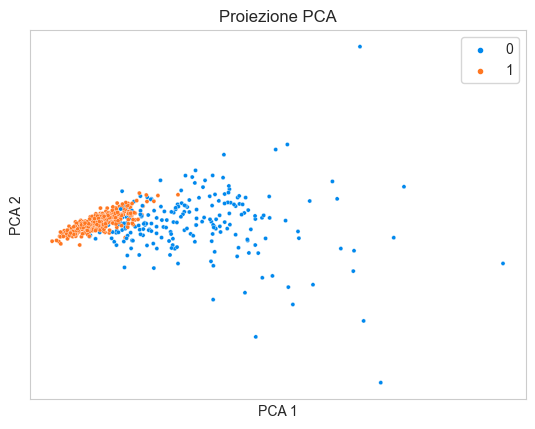

In [5]:
import seaborn as sns
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)

X = df.drop("target", axis=1).values
y = df["target"].values

vecs = pca.fit_transform(X)
x0 = vecs[:, 0]
x1 = vecs[:, 1]

sns.set_style("whitegrid")
sns.scatterplot(x=x0, y=x1, hue=y)
plt.title("Proiezione PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.xticks([])
plt.yticks([])
plt.show()

We see how class 1 data points group based on common characteristics. It will be the goal of our neural network to classify the rows between targets 0 or 1.

# Create the datasets and dataloaders classes

PyTorch provides `Dataset` and `DataLoader` objects to allow us to efficiently organize and load our data into the neural network.

It would be possible to use pandas directly, but this would have disadvantages because it would make our code less efficient.

The `Dataset` class allows us to specify the right format for your data and apply the retrieval and transformation logics that are often fundamental (think of the data augmentation applied to images).

In [6]:
from torch.utils.data import Dataset


class BreastCancerDataset(Dataset):
    def __init__(self, X, y):
        # create feature tensors
        self.features = torch.tensor(X, dtype=torch.float32)
        # create label tensors
        self.labels = torch.tensor(
            y, dtype=torch.long
        )  # torch.long is equivalent to torch.int64

    def __len__(self):
        # we define a method to retrieve the length of the dataset
        return self.features.shape[0]

    def __getitem__(self, idx):
        # necessary override of the __getitem__ method which helps to index our data
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

This is a class that inherits from `Dataset` and allows the `DataLoader`, which we will create shortly, to efficiently retrieve batches of data.

# Training, validation and test datasets

These will help us evaluate the performance of our model and understand the quality of the predictions.

With Sklearn this becomes easy with the `train_test_split` method.

In [7]:
from sklearn import model_selection

train_ratio = 0.50
validation_ratio = 0.20
test_ratio = 0.20

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=1 - train_ratio
)
x_val, x_test, y_val, y_test = model_selection.train_test_split(
    x_test, y_test, test_size=test_ratio / (test_ratio + validation_ratio)
)

print(x_train.shape, x_val.shape, x_test.shape)

(284, 30) (142, 30) (143, 30)


With this small snippet of code we created our training, validation and test sets according to controllable splits.

# Data normalization

When doing deep learning, even for a simple task like binary classification, **it is always necessary to normalize our data.**

Normalizing means bringing all the values of the various columns in the dataset to the same numerical scale. This helps the neural network converge more effectively and thus make accurate predictions faster.

In [8]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

Notice how `fit_trasform` is applied only to the training set, while `transform` is applied to the other two datasets. This is to avoid data leakage — when information from our validation or test set is unintentionally leaked into our training set. We want our training set to be the only source of learning, unaffected by test data.

This data is now ready to be input to the `BreastCancerDataset` class.

In [9]:
train_dataset = BreastCancerDataset(x_train_scaled, y_train)
val_dataset = BreastCancerDataset(x_val_scaled, y_val)
test_dataset = BreastCancerDataset(x_test_scaled, y_test)

We import the dataloader and initialize the objects.

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset, batch_size=16, shuffle=True, drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset, batch_size=16, shuffle=False, drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset, batch_size=16, shuffle=False, drop_last=True
)

The power of the `DataLoader` is that it allows us to specify whether to shuffling our data and in what number of batches the data should be supplied to the model. **The batch size is to be considered a hyperparameter** of the model and therefore can impact the results of our inferences.

# Neural network implementation in PyTorch

Creating a model in PyTorch might sound complex, but it really only requires understanding a few basic concepts.

1. When writing a model in PyTorch, we will use an **object-based approach**, like with datasets. It means that we will create a class like class `MyModel` which inherits from PyTorch’s `nn.Module` class.
2. PyTorch is an autodifferentiation software. It means that when we write a neural network based on the backpropagation algorithm, the calculation of the derivatives to calculate the loss is done automatically behind the scenes. This requires writing some dedicated code that might get confusing the first time around.

That said, let’s see what the code for writing a logistic regression model looks like.

In [11]:
from torch import nn


class LogisticRegression(nn.Module):
    """
    Our neural network accepts num_features and num_classes.

    num_features: number of features to learn from
    num_classes: number of classes in output to expect (in this case, 1 or 2, since the output is binary (0 or 1))
    """

    def __init__(self, num_features, num_classes):
        super().__init__()  # initialize the init method of nn.Module

        self.num_features = num_features
        self.num_classes = num_classes

        # create a single layer of neurons on which to apply the log reg
        self.linear1 = nn.Linear(in_features=num_features, out_features=num_classes)

    def forward(self, x):
        logits = self.linear1(x)  # pass our data through the layer
        # we apply a sigmoid function to obtain the probabilities of belonging to a class (0 or 1)
        probs = torch.sigmoid(logits)
        return probs  # return probabilities

# Utility functions for plotting and accuracy calculation

Let’s create utility functions to use in the training loop that we will see shortly. These two are used to compute the accuracy at the end of each epoch and to display the performance curves at the end of the training.

In [12]:
def compute_accuracy(model, dataloader):
    """
    This function puts the model in evaluation mode (model.eval()) and
    calculates the accuracy with respect to the input dataloader
    """
    model = model.eval()
    correct = 0
    total_examples = 0
    for idx, (features, labels) in enumerate(dataloader):
        with torch.no_grad():
            logits = model(features)
        predictions = torch.where(logits > 0.5, 1, 0)
        lab = labels.view(predictions.shape)
        comparison = lab == predictions

        correct += torch.sum(comparison)
        total_examples += len(comparison)
    return correct / total_examples

In [13]:
def plot_results(train_loss, val_loss, train_acc, val_acc):
    """
    This function takes lists of values and creates side-by-side graphs
    to show training and validation performance
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(
        train_loss, label="train", color="red", linestyle="--", linewidth=2, alpha=0.5
    )
    ax[0].plot(
        val_loss, label="val", color="blue", linestyle="--", linewidth=2, alpha=0.5
    )
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[1].plot(
        train_acc, label="train", color="red", linestyle="--", linewidth=2, alpha=0.5
    )
    ax[1].plot(
        val_acc, label="val", color="blue", linestyle="--", linewidth=2, alpha=0.5
    )
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    plt.show()

# Model training

Now we come to the part where **most deep learning newcomers struggle: the PyTorch training loop.**

In [14]:
import torch.nn.functional as F

model = LogisticRegression(num_features=x_train_scaled.shape[1], num_classes=1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model = model.train()
    t_loss_list, v_loss_list = [], []
    for batch_idx, (features, labels) in enumerate(train_loader):
        train_probs = model(features)
        train_probs = train_probs.type(torch.FloatTensor)  # Added by me to avoid error
        labels = labels.type(torch.FloatTensor)  # Added by me to avoid error
        train_loss = F.binary_cross_entropy(train_probs, labels.view(train_probs.shape))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(
                f"Epoch {epoch+1:02d}/{num_epochs:02d}"
                f" | Batch {batch_idx:02d}/{len(train_loader):02d}"
                f" | Train Loss {train_loss:.3f}"
            )

        t_loss_list.append(train_loss.item())

    model = model.eval()
    for batch_idx, (features, labels) in enumerate(val_loader):
        with torch.no_grad():
            val_probs = model(features)
            val_probs = val_probs.type(torch.FloatTensor)  # Added by me to avoid error
            labels = labels.type(torch.FloatTensor)  # Added by me to avoid error
            val_loss = F.binary_cross_entropy(val_probs, labels.view(val_probs.shape))
            v_loss_list.append(val_loss.item())

    train_losses.append(np.mean(t_loss_list))
    val_losses.append(np.mean(v_loss_list))

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train accuracy: {train_acc:.2f}" f" | Val accuracy: {val_acc:.2f}")

Epoch 01/10 | Batch 00/17 | Train Loss 0.762
Epoch 01/10 | Batch 10/17 | Train Loss 0.499
Train accuracy: 0.86 | Val accuracy: 0.80
Epoch 02/10 | Batch 00/17 | Train Loss 0.506
Epoch 02/10 | Batch 10/17 | Train Loss 0.407
Train accuracy: 0.89 | Val accuracy: 0.85
Epoch 03/10 | Batch 00/17 | Train Loss 0.476
Epoch 03/10 | Batch 10/17 | Train Loss 0.442
Train accuracy: 0.90 | Val accuracy: 0.88
Epoch 04/10 | Batch 00/17 | Train Loss 0.363
Epoch 04/10 | Batch 10/17 | Train Loss 0.257
Train accuracy: 0.93 | Val accuracy: 0.91
Epoch 05/10 | Batch 00/17 | Train Loss 0.387
Epoch 05/10 | Batch 10/17 | Train Loss 0.482
Train accuracy: 0.93 | Val accuracy: 0.91
Epoch 06/10 | Batch 00/17 | Train Loss 0.259
Epoch 06/10 | Batch 10/17 | Train Loss 0.252
Train accuracy: 0.93 | Val accuracy: 0.94
Epoch 07/10 | Batch 00/17 | Train Loss 0.218
Epoch 07/10 | Batch 10/17 | Train Loss 0.244
Train accuracy: 0.93 | Val accuracy: 0.95
Epoch 08/10 | Batch 00/17 | Train Loss 0.255
Epoch 08/10 | Batch 10/17 | Tra

Let’s see the procedure step by step:

1. We instantiate the model and the optimizer
2. We decide on a number of epochs
3. We create a for loop that iterates through the epochs
4. For each epoch, we set the model to training mode with `model.train()` and cycle through the `train_loader`
5. For each batch of the `train_loader`, calculate the loss, bring the calculation of the derivatives to 0 with `optimizer.zero_grad()` and update the weights of the network with `optimizer.step()`

At this point the training loop is complete, and if you want you can integrate the same logic on the validation dataloader as written in the code.

# Neural network performance evaluation

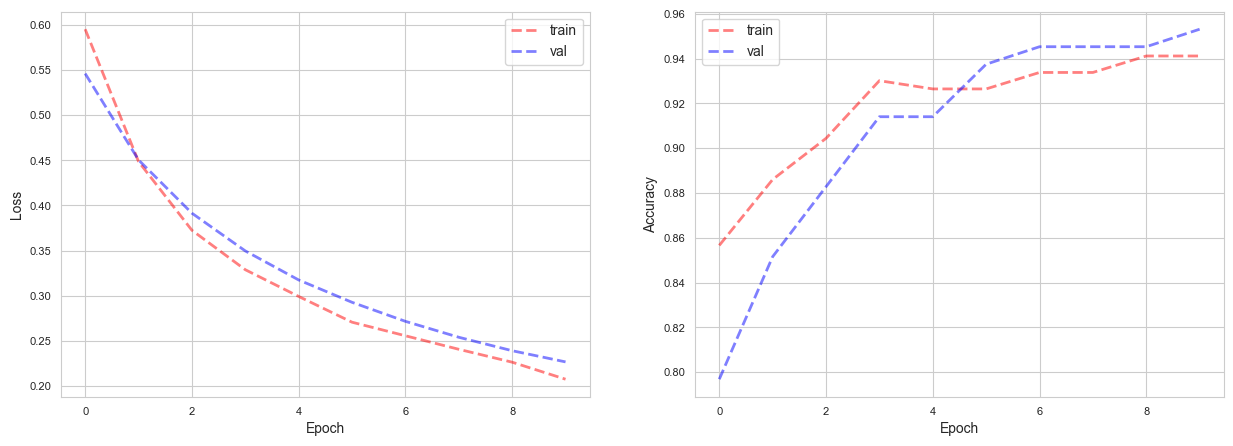

In [15]:
plot_results(train_losses, val_losses, train_accs, val_accs)

Our binary classification model quickly converges to high accuracy, and we see how the loss drops at the end of each epoch.

The dataset turns out to be simple to model and the low number of examples does not help to see a more gradual convergence towards high performance by the network.

I emphasize that it is possible to integrate the **TensorBoard** software into PyTorch to be able to log performance metrics automatically between the various experiments.

# Create predictions

We have reached the end of this guide. Let’s see the code to create predictions for our entire dataset.

In [16]:
# we transform all our features with the scaler
X_scaled_all = scaler.transform(X)

# transform in tensors
X_scaled_all_tensors = torch.tensor(X_scaled_all, dtype=torch.float32)

# we set the model in inference mode and create the predictions
with torch.inference_mode():
    logits = model(X_scaled_all_tensors)
    predictions = torch.where(logits > 0.5, 1, 0)

df["predictions"] = predictions.numpy().flatten()

In [17]:
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,predictions
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0,0


Now let’s import the `metrics` package from Sklearn which allows us to quickly calculate the confusion matrix and classification report directly on our pandas dataframe.

In [18]:
from sklearn import metrics

# from pprint import pprint

print(metrics.classification_report(y_pred=df.predictions, y_true=df.target))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       212
           1       0.96      0.96      0.96       357

    accuracy                           0.94       569
   macro avg       0.94      0.94      0.94       569
weighted avg       0.94      0.94      0.94       569



And the confusion matrix, which shows the number of correct answers on the diagonal

In [19]:
metrics.confusion_matrix(y_pred=df.predictions, y_true=df.target)

array([[196,  16],
       [ 16, 341]], dtype=int64)

Here is a small function to create a classification line that separates the classes in the PCA graph

In [20]:
def plot_boundary(model):
    w1 = model.linear1.weight[0][0].detach()
    w2 = model.linear1.weight[0][1].detach()
    b = model.linear1.bias[0].detach()

    x1_min = -1000
    x2_min = (-(w1 * x1_min) - b) / w2

    x1_max = 1000
    x2_max = (-(w1 * x1_max) - b) / w2

    return x1_min, x1_max, x2_min, x2_max

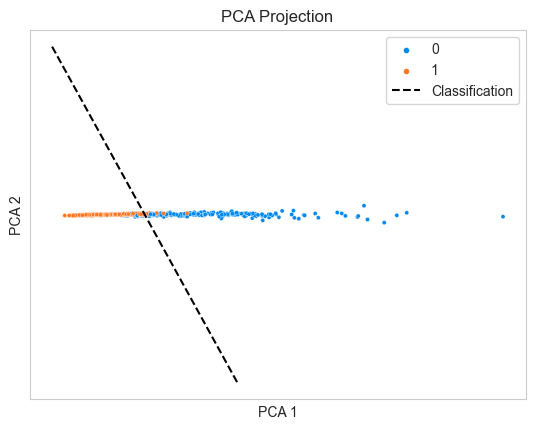

In [21]:
x1_min, x1_max, x2_min, x2_max = plot_boundary(model)

sns.scatterplot(x=x0, y=x1, hue=y)
plt.title("PCA Projection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.xticks([])
plt.yticks([])
plt.plot(
    [x1_min, x1_max],
    [x2_min, x2_max],
    color="k",
    label="Classification",
    linestyle="--",
)
plt.legend()
plt.show()